In [2]:
import sys
import scanpy as sc
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import celltypist
from celltypist import models
from scipy.stats import median_abs_deviation as mad

In [2]:

print(sys.version)


3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:45:18) [GCC 12.3.0]


In [2]:

files = os.listdir('SLEsinglecell')

In [6]:
!mkdir raw_adata

In [4]:
def get_sample_prefix(files):
    parts = files.split('_')
    return '_'.join(parts[:3]) + '_'


for prefix in set([get_sample_prefix(x) for x in files if 'samples' not in x and 'filtered' not in x and not x.startswith('.')]):
    #print(prefix)
    adata = sc.read_10x_mtx('SLEsinglecell/', prefix = prefix)
    adata.write_h5ad('raw_adata/' + prefix +'.h5ad')

It looks like the data is already filtered. So cellbender did not do much. we can just use the raw adata for the following analysis

In [5]:
# load the data
def load(adata):
    patient = adata.split('_')[1]
    treat = adata.split('_')[2]
    adata = sc.read_h5ad('raw_adata/' + adata)
    adata.obs['Patient'] = patient
    adata.obs['treat'] = treat
    adata.obs['Sample'] = adata.obs['Patient'] +'_' + adata.obs['treat']
    adata.obs.index = adata.obs.index + patient + '_' + treat
    return adata

In [7]:
adatas = [load(ad) for ad in os.listdir('raw_adata/')]

In [8]:
adatas

[AnnData object with n_obs × n_vars = 11069 × 36601
     obs: 'Patient', 'treat', 'Sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 3966 × 36601
     obs: 'Patient', 'treat', 'Sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 6943 × 36601
     obs: 'Patient', 'treat', 'Sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 2633 × 36601
     obs: 'Patient', 'treat', 'Sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 19647 × 36601
     obs: 'Patient', 'treat', 'Sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 14853 × 36601
     obs: 'Patient', 'treat', 'Sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 5185 × 36601
     obs: 'Patient', 'treat', 'Sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 7832 × 36601
     obs: 'Patient', 'treat', 'Sample'
    

In [9]:
def qc(adata):
    sc.pp.filter_cells(adata, min_genes=200)
    adata.var['mt'] = adata.var_names.str.startswith('MT-') #Find mito genes and store them in var col
    adata.var['ribo'] = adata.var_names.str.startswith('RPS', 'RPL')
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], inplace=True, percent_top=[20], log1p=True)
    return adata

    


In [10]:
adatas = [qc(ad) for ad in adatas]

In [13]:
df = pd.concat([x.obs for x in adatas])
df = df.sort_values('Sample')

In [46]:
df.head()

Patient treat     Sample  n_genes  \
CTCTAATTCTTCGGTC-1pat1_post    pat1  post  pat1_post     1416   
CCGTTCAAGCTAAGAT-1pat1_post    pat1  post  pat1_post     2610   
CCGTTCAAGCACCGCT-1pat1_post    pat1  post  pat1_post     1593   
CCGTGGATCGCACTCT-1pat1_post    pat1  post  pat1_post     1672   
CCGTGGATCCTAGTGA-1pat1_post    pat1  post  pat1_post     1762   

                             n_genes_by_counts  log1p_n_genes_by_counts  \
CTCTAATTCTTCGGTC-1pat1_post               1416                 7.256297   
CCGTTCAAGCTAAGAT-1pat1_post               2610                 7.867489   
CCGTTCAAGCACCGCT-1pat1_post               1593                 7.374002   
CCGTGGATCGCACTCT-1pat1_post               1672                 7.422374   
CCGTGGATCCTAGTGA-1pat1_post               1762                 7.474772   

                             total_counts  log1p_total_counts  \
CTCTAATTCTTCGGTC-1pat1_post        3665.0            8.206857   
CCGTTCAAGCTAAGAT-1pat1_post        6339.0            8.754634   
CCGTTCAAGCACCGCT-1pat1_post        3386.0            8.127700   
CCGTGGATCGCACTCT-1pat1_post        6158.0            8.725670   
CCGTGGATCCTAGTGA-1pat1_post        4714.0            8.458504   

                             pct_counts_in_top_20_genes  total_counts_mt  \
CTCTAATTCTTCGGTC-1pat1_post                   22.237381            148.0   
CCGTTCAAGCTAAGAT-1pat1_post                   12.762265            131.0   
CCGTTCAAGCACCGCT-1pat1_post                   17.720024             67.0   
CCGTGGATCGCACTCT-1pat1_post                   25.349139            124.0   
CCGTGGATCCTAGTGA-1pat1_post                   20.661858            169.0   

                             log1p_total_counts_mt  pct_counts_mt  \
CTCTAATTCTTCGGTC-1pat1_post               5.003946       4.038199   
CCGTTCAAGCTAAGAT-1pat1_post               4.882802       2.066572   
CCGTTCAAGCACCGCT-1pat1_post               4.219508       1.978736   
CCGTGGATCGCACTCT-1pat1_post               4.828314       2.013641   
CCGTGGATCCTAGTGA-1pat1_post               5.135798       3.585066   

                             total_counts_ribo  log1p_total_counts_ribo  \
CTCTAATTCTTCGGTC-1pat1_post              522.0                 6.259582   
CCGTTCAAGCTAAGAT-1pat1_post              369.0                 5.913503   
CCGTTCAAGCACCGCT-1pat1_post              241.0                 5.488938   
CCGTGGATCGCACTCT-1pat1_post             1174.0                 7.069024   
CCGTGGATCCTAGTGA-1pat1_post              602.0                 6.401917   

                             pct_counts_ribo  
CTCTAATTCTTCGGTC-1pat1_post        14.242838  
CCGTTCAAGCTAAGAT-1pat1_post         5.821107  
CCGTTCAAGCACCGCT-1pat1_post         7.117543  
CCGTGGATCGCACTCT-1pat1_post        19.064632  
CCGTGGATCCTAGTGA-1pat1_post        12.770471

/data/hps/assoc/private/gdml/user/yhao1/envs/singlecell/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/data/hps/assoc/private/gdml/user/yhao1/envs/singlecell/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/data/hps/assoc/private/gdml/user/yhao1/envs/singlecell/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/data/hps/assoc/private/gdml/user/yhao1/envs/singlecell/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_la

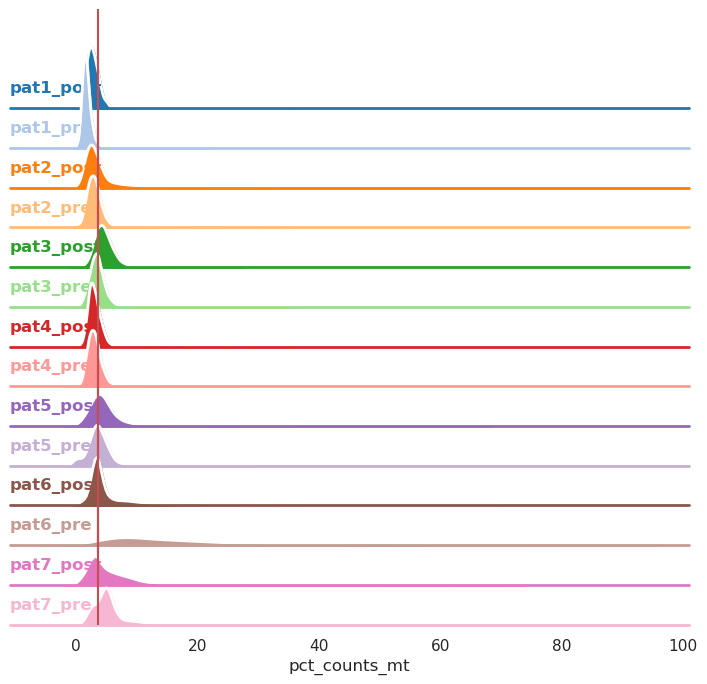

In [14]:


value = 'pct_counts_mt'
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

g = sns.FacetGrid(df, row="Sample", hue="Sample", aspect=15, height=0.5, palette="tab20")

g.map(sns.kdeplot, value, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, value, clip_on=False, color="w", lw=2)

g.map(plt.axhline, y=0, lw=2, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, value)

g.figure.subplots_adjust(hspace=-.6)

g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

for ax in g.axes.flat:
    ax.axvline(x=df[value].median(), color='r', linestyle='-')


plt.show()

/data/hps/home/yhao1/miniforge3/envs/singlecell/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/data/hps/home/yhao1/miniforge3/envs/singlecell/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/data/hps/home/yhao1/miniforge3/envs/singlecell/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/data/hps/home/yhao1/miniforge3/envs/singlecell/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height sma

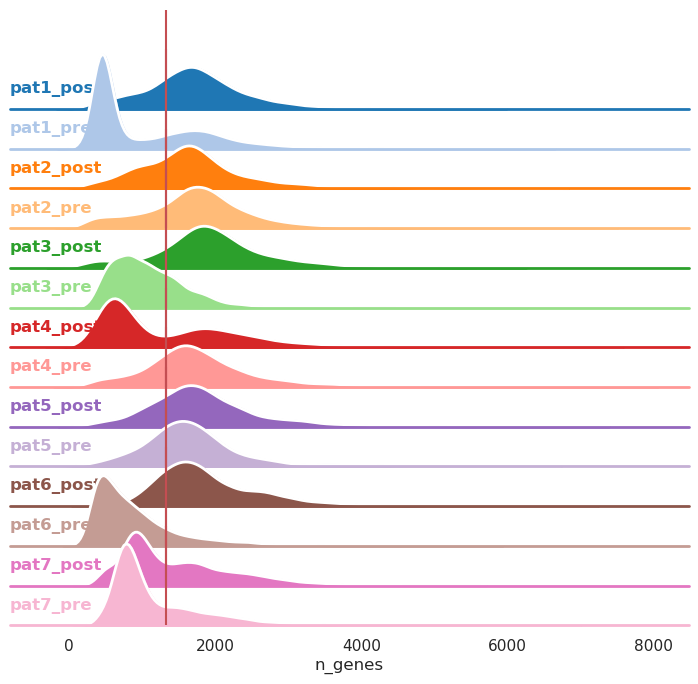

In [49]:


value = 'n_genes'
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

g = sns.FacetGrid(df, row="Sample", hue="Sample", aspect=15, height=0.5, palette="tab20")

g.map(sns.kdeplot, value, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, value, clip_on=False, color="w", lw=2)

g.map(plt.axhline, y=0, lw=2, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, value)

g.figure.subplots_adjust(hspace=-.6)

g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

for ax in g.axes.flat:
    ax.axvline(x=df[value].median(), color='r', linestyle='-')


plt.show()

/data/hps/home/yhao1/miniforge3/envs/singlecell/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/data/hps/home/yhao1/miniforge3/envs/singlecell/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/data/hps/home/yhao1/miniforge3/envs/singlecell/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/data/hps/home/yhao1/miniforge3/envs/singlecell/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height sma

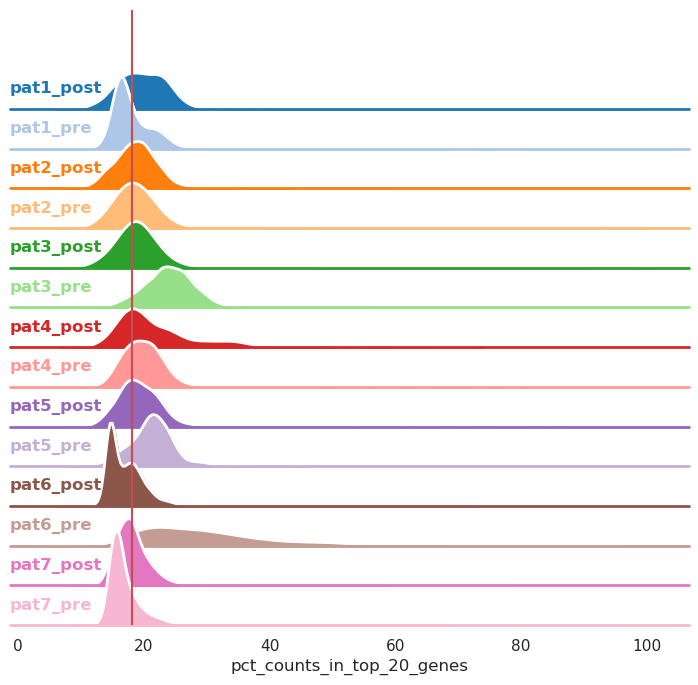

In [50]:


value = 'pct_counts_in_top_20_genes'
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

g = sns.FacetGrid(df, row="Sample", hue="Sample", aspect=15, height=0.5, palette="tab20")

g.map(sns.kdeplot, value, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, value, clip_on=False, color="w", lw=2)

g.map(plt.axhline, y=0, lw=2, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, value)

g.figure.subplots_adjust(hspace=-.6)

g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

for ax in g.axes.flat:
    ax.axvline(x=df[value].median(), color='r', linestyle='-')


plt.show()

Preprocessing

In [16]:
# function to filter the cells on total counts

def mad_outlier(adata, metric, nmads, upper_only = False):
    M = adata.obs[metric]
    if not upper_only:
        return (M < np.median(M) - nmads * mad(M)) | (M > np.median(M) + nmads * mad(M))
    
    return (M > np.median(M) + nmads * mad(M))


In [17]:
def pp(adata):
    
    

    adata = adata[adata.obs.pct_counts_mt < 25] #you can lower this based on the overal distribution of your dataset
    
    bool_vector = mad_outlier(adata, 'log1p_total_counts', 5) +\
            mad_outlier(adata, 'log1p_n_genes_by_counts', 5) +\
            mad_outlier(adata, 'pct_counts_in_top_20_genes', 5) +\
            mad_outlier(adata, 'pct_counts_mt', 3, upper_only = True)
    adata = adata[~bool_vector]

    adata.uns['cells_removed'] = sum(bool_vector)


    

    return adata

In [18]:


adatas = [pp(ad) for ad in adatas]




/tmp/ipykernel_696352/3015868492.py:13: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['cells_removed'] = sum(bool_vector)


In [26]:
for i, adata in enumerate(adatas):
    adata.write(os.path.join('pp_adata', f'adata_{i}_outlierremoval.h5ad'))

In [ ]:
import doubletdetection


number_of_adatas = 14

adatas = [sc.read_h5ad(os.path.join('singlecell', 'pp_adata', f'adata_{i}_outlierremoval.h5ad')) for i in range(number_of_adatas)]

clf = doubletdetection.BoostClassifier(
    n_iters=10,
    clustering_algorithm="louvain",
    standard_scaling=True,
    pseudocount=0.1,
    n_jobs=-1)

def pp(adata):
    

    doublets = clf.fit(adata.X).predict(p_thresh=1e-3, voter_thresh=0.5)
    doublet_score = clf.doublet_score()

    adata.obs["doublet"] = doublets
    adata.obs["doublet_score"] = doublet_score

    adata.uns['doublets_removed'] = adata.obs.doublet.sum()
    adata = adata[adata.obs.doublet == 0]

    return adata

adatas = [pp(ad) for ad in adatas]

for i, adata in enumerate(adatas):
    adata.write(os.path.join('singlecell', 'pp_adata', f'adata_{i}_doubletremoval.h5ad'))


In [17]:
number_of_adatas = 14

adatas = [sc.read_h5ad(os.path.join('pp_adata', f'adata_{i}_doubletremoval.h5ad')) for i in range(number_of_adatas)]


In [24]:
adatas[0].var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.5', 'AL627309.4', 'AP006222.2', 'AL732372.1',
       ...
       'AC133551.1', 'AC136612.1', 'AC136616.1', 'AC136616.3', 'AC136616.2',
       'AC141272.1', 'AC023491.2', 'AC007325.1', 'AC007325.4', 'AC007325.2'],
      dtype='object', length=36601)

In [35]:
for adata in adatas:
    print(len(adata), adata.uns['cells_removed'], adata.uns['doublets_removed'])

6485 2098 2483.0
3330 350 215.0
4809 110 551.0
2070 424 128.0
14156 2560 2840.0
11078 1693 2020.0
4337 456 386.0
5974 861 858.0
4829 311 744.0
5683 756 380.0
8163 2260 910.0
5155 853 261.0
375 46 0.0
1683 251 89.0


In [37]:

#from celltypist import models

In [14]:
models.get_all_models()

🔎 No available models. Downloading...
📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 50
📂 Storing models in /data/hps/home/yhao1/.celltypist/data/models
💾 Downloading model [1/50]: Immune_All_Low.pkl
💾 Downloading model [2/50]: Immune_All_High.pkl
💾 Downloading model [3/50]: Adult_COVID19_PBMC.pkl
💾 Downloading model [4/50]: Adult_CynomolgusMacaque_Hippocampus.pkl
💾 Downloading model [5/50]: Adult_Human_PancreaticIslet.pkl
💾 Downloading model [6/50]: Adult_Human_Skin.pkl
💾 Downloading model [7/50]: Adult_Mouse_Gut.pkl
💾 Downloading model [8/50]: Adult_Mouse_OlfactoryBulb.pkl
💾 Downloading model [9/50]: Adult_Pig_Hippocampus.pkl
💾 Downloading model [10/50]: Adult_RhesusMacaque_Hippocampus.pkl
💾 Downloading model [11/50]: Autopsy_COVID19_Lung.pkl
💾 Downloading model [12/50]: COVID19_HumanChallenge_Blood.pkl
💾 Downloading model [13/50]: COVID19_Immune_Landscape.pkl
💾 Downloading model [14/50]: Cells_Adult_Breast.pkl
💾 Dow

['Adult_Human_Skin.pkl',
 'Mouse_Isocortex_Hippocampus.pkl',
 'Autopsy_COVID19_Lung.pkl',
 'Human_AdultAged_Hippocampus.pkl',
 'Healthy_Mouse_Liver.pkl',
 'Adult_RhesusMacaque_Hippocampus.pkl',
 'Pan_Fetal_Human.pkl',
 'Healthy_Adult_Heart.pkl',
 'Human_Lung_Atlas.pkl',
 'Fetal_Human_AdrenalGlands.pkl',
 'Healthy_COVID19_PBMC.pkl',
 'Cells_Adult_Breast.pkl',
 'Fetal_Human_Pituitary.pkl',
 'Human_IPF_Lung.pkl',
 'COVID19_Immune_Landscape.pkl',
 'Mouse_Whole_Brain.pkl',
 'Developing_Human_Gonads.pkl',
 'Cells_Fetal_Lung.pkl',
 'Developing_Mouse_Hippocampus.pkl',
 'Developing_Human_Brain.pkl',
 'Developing_Mouse_Brain.pkl',
 'Mouse_Dentate_Gyrus.pkl',
 'Fetal_Human_Pancreas.pkl',
 'Fetal_Human_Retina.pkl',
 'Human_Longitudinal_Hippocampus.pkl',
 'Adult_Pig_Hippocampus.pkl',
 'Developing_Human_Hippocampus.pkl',
 'Immune_All_High.pkl',
 'Developing_Human_Thymus.pkl',
 'Cells_Human_Tonsil.pkl',
 'Adult_CynomolgusMacaque_Hippocampus.pkl',
 'Immune_All_Low.pkl',
 'Developing_Human_Organs.pkl',

In [16]:
model_immune = models.Model.load(model='Immune_All_Low.pkl')
model_pbmc = models.Model.load(model='Healthy_COVID19_PBMC.pkl')
model_ref = models.Model.load(model='ref.pkl')


***************************************************

ref dataset: Single-cell eQTL mapping identifies cell type specific genetic control of autoimmune disease

In [32]:


# Load the entire dataset
radata = sc.read_h5ad('sciencepaper_ref.h5ad')




In [3]:
radata

AnnData object with n_obs × n_vars = 1248980 × 36469
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'donor_id', 'pool_number', 'predicted.celltype.l2', 'predicted.celltype.l2.score', 'age', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'
    uns: 'cell_type_ontology_term_id_colors', 'citation', 'default_embedding', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_azimuth_spca', 'X_a

In [33]:
radata.var_names

Index(['ENSG00000243485', 'ENSG00000237613', 'ENSG00000186092',
       'ENSG00000238009', 'ENSG00000239945', 'ENSG00000239906',
       'ENSG00000241860', 'ENSG00000241599', 'ENSG00000286448',
       'ENSG00000236601',
       ...
       'ENSG00000198712', 'ENSG00000228253', 'ENSG00000198899',
       'ENSG00000198938', 'ENSG00000198840', 'ENSG00000212907',
       'ENSG00000198886', 'ENSG00000198786', 'ENSG00000198695',
       'ENSG00000198727'],
      dtype='object', length=36469)

In [38]:
sc.pp.normalize_total(radata, target_sum=1e4)
sc.pp.log1p(radata)

In [6]:
radata.obs.groupby('cell_type').size()

cell_type
erythrocyte                                                 290
platelet                                                   1810
dendritic cell                                              181
natural killer cell                                      164933
CD4-positive, alpha-beta T cell                             773
CD8-positive, alpha-beta T cell                             305
plasmacytoid dendritic cell                                1897
memory B cell                                             30234
naive B cell                                              65702
gamma-delta T cell                                        18922
regulatory T cell                                         26531
transitional stage B cell                                 29889
naive thymus-derived CD4-positive, alpha-beta T cell     259012
naive thymus-derived CD8-positive, alpha-beta T cell      52538
central memory CD4-positive, alpha-beta T cell           289000
effector memory CD4-positive, 

In [39]:
sc.pp.filter_genes(radata, min_cells=10)
sc.pp.filter_cells(radata, min_genes=200)

In [8]:
radata.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 1185477628 stored elements and shape (1248980, 26347)>

We got problem here as the gene names are 2 different naming systems.

In [ ]:
from pybiomart import Server

server = Server(host='http://www.ensembl.org')
dataset = server.marts['ENSEMBL_MART_ENSEMBL'].datasets['hsapiens_gene_ensembl']
genes = dataset.query(attributes=['ensembl_gene_id', 'external_gene_name'])

# Save to CSV
genes.to_csv('ensembl_to_symbol_mapping.csv', index=False)

In [ ]:
# Load the mapping
mapping = pd.read_csv('ensembl_to_symbol_mapping.csv')

print(mapping.columns)

# Drop rows where any of these two columns are NA
mapping.dropna(subset=['Gene stable ID', 'Gene name'], inplace=True)


In [34]:
ensembl_to_symbol = dict(zip(mapping['Gene stable ID'], mapping['Gene name']))

# Example of changing ref_model features assuming it's a list or similar structure
radata.var_names = [ensembl_to_symbol.get(gene_id, gene_id) for gene_id in radata.var_names]


In [35]:
radata.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'ENSG00000238009', 'ENSG00000239945',
       'ENSG00000239906', 'ENSG00000241860', 'ENSG00000241599',
       'ENSG00000286448', 'ENSG00000236601',
       ...
       'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4',
       'MT-ND5', 'MT-ND6', 'MT-CYB'],
      dtype='object', length=36469)

In [40]:
radata.write_h5ad('processed_ref_adata.h5ad')


In [ ]:
radata = sc.read_h5ad('processed_ref_adata.h5ad')

/data/hps/assoc/private/gdml/user/yhao1/envs/singlecell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:384: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)


In [10]:
radata

AnnData object with n_obs × n_vars = 1248980 × 26347
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'donor_id', 'pool_number', 'predicted.celltype.l2', 'predicted.celltype.l2.score', 'age', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'n_cells'
    uns: 'cell_type_ontology_term_id_colors', 'citation', 'default_embedding', 'schema_reference', 'schema_version', 'title', 'log1p'
 

In [15]:
radata.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 77457048 stored elements and shape (40724, 1902)>

In [161]:
print(adata.obs['cell_type'].unique())
print(adata.obs['cell_type'].isna().sum())

['CD4-positive, alpha-beta T cell', 'classical monocyte', 'B cell', 'CD8-positive, alpha-beta T cell', 'natural killer cell', ..., 'lymphocyte', 'conventional dendritic cell', 'plasmacytoid dendritic cell', 'plasmablast', 'progenitor cell']
Length: 11
Categories (11, object): ['B cell', 'lymphocyte', 'natural killer cell', 'CD4-positive, alpha-beta T cell', ..., 'non-classical monocyte', 'plasmablast', 'conventional dendritic cell', 'progenitor cell']
0


In [41]:

ref_model = celltypist.train(radata, labels='cell_type', n_jobs=22, use_SGD=True, feature_selection=True, top_genes=300)

🍳 Preparing data before training
🔬 Input data has 1248980 cells and 26347 genes
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
⚠️ Warning: it may take a long time to train this dataset with 1248980 cells and 26347 genes, try to downsample cells and/or restrict genes to a subset (e.g., hvgs)
🔎 Selecting features
🧬 2558 features are selected
🏋️ Starting the second round of training
🏋️ Training data using SGD logistic regression
✅ Model training done!


In [42]:
ref_model.write('ref.pkl')

In [43]:
ref_model.features

array(['HES4', 'ISG15', 'TTLL10', ..., 'MT-ND4', 'MT-ND5', 'MT-CYB'],
      dtype=object)

***************************************

In [50]:
def predict_cells(adata):
    sc.pp.filter_genes(adata, min_cells = 10)
    sc.pp.normalize_total(adata, target_sum=1e4) #not recommended for typical pp
    sc.pp.log1p(adata)

    adata.X = adata.X.toarray()

    predictions = celltypist.annotate(adata, model=model_immune, majority_voting=False)
    predictions_adata = predictions.to_adata()
    adata.obs["immune_label"] = predictions_adata.obs.loc[adata.obs.index, "predicted_labels"]
    adata.obs["immune_score"] = predictions_adata.obs.loc[adata.obs.index, "conf_score"]

    predictions = celltypist.annotate(adata, model=model_pbmc, majority_voting=False)
    predictions_adata = predictions.to_adata()
    adata.obs["pbmc_label"] = predictions_adata.obs.loc[adata.obs.index, "predicted_labels"]
    adata.obs["pbmc_score"] = predictions_adata.obs.loc[adata.obs.index, "conf_score"]

    predictions = celltypist.annotate(adata, model=ref_model, majority_voting=False)
    predictions_adata = predictions.to_adata()
    adata.obs["ref_label"] = predictions_adata.obs.loc[adata.obs.index, "predicted_labels"]
    adata.obs["ref_score"] = predictions_adata.obs.loc[adata.obs.index, "conf_score"]



    return adata.obs

In [51]:
predictions = [predict_cells(ad.copy()) for ad in adatas]

🔬 Input data has 6485 cells and 12986 genes
🔗 Matching reference genes in the model
🧬 4597 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 6485 cells and 12986 genes
🔗 Matching reference genes in the model
🧬 2999 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 6485 cells and 12986 genes
🔗 Matching reference genes in the model
🧬 2241 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 3330 cells and 14658 genes
🔗 Matching reference genes in the model
🧬 4813 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 3330 cells and 14658 genes
🔗 Matching reference genes in the model
🧬 3105 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 3330 cells and 14658 genes
🔗 Matching reference genes in the model
🧬 2286

In [52]:
predictions = pd.concat(predictions)[['immune_label', 'immune_score', 'pbmc_label', 'pbmc_score', 'ref_label', 'ref_score']]
predictions

immune_label  immune_score  \
AAACCTGAGCGCTCCA-1pat1_pre   Tem/Temra cytotoxic T cells      0.255952   
AAACCTGAGCTCCTTC-1pat1_pre           Classical monocytes      0.988472   
AAACCTGAGGAGCGAG-1pat1_pre   Tem/Temra cytotoxic T cells      0.848297   
AAACCTGAGGCGATAC-1pat1_pre   Tem/Effector helper T cells      0.476349   
AAACCTGCAAGGGTCA-1pat1_pre           Classical monocytes      0.421689   
...                                                  ...           ...   
TTTGTCAAGCTACCGC-1pat3_post    Tem/Trm cytotoxic T cells      0.994078   
TTTGTCAAGGGTGTTG-1pat3_post                          DC2      0.716049   
TTTGTCAGTCTTCAAG-1pat3_post  Tem/Temra cytotoxic T cells      0.999922   
TTTGTCAGTTCCACTC-1pat3_post          Classical monocytes      0.963069   
TTTGTCATCCTTCAAT-1pat3_post          Classical monocytes      0.999996   

                            pbmc_label  pbmc_score  \
AAACCTGAGCGCTCCA-1pat1_pre      CD8.TE    0.513954   
AAACCTGAGCTCCTTC-1pat1_pre   CD14_mono    0.946049   
AAACCTGAGGAGCGAG-1pat1_pre   CD8.Naive    0.590351   
AAACCTGAGGCGATAC-1pat1_pre   CD14_mono    0.947987   
AAACCTGCAAGGGTCA-1pat1_pre         RBC    0.858330   
...                                ...         ...   
TTTGTCAAGCTACCGC-1pat3_post       MAIT    0.697224   
TTTGTCAAGGGTGTTG-1pat3_post        DC3    0.962833   
TTTGTCAGTCTTCAAG-1pat3_post     CD8.TE    0.407009   
TTTGTCAGTTCCACTC-1pat3_post  CD14_mono    0.993269   
TTTGTCATCCTTCAAT-1pat3_post  CD14_mono    0.998777   

                                                                   ref_label  \
AAACCTGAGCGCTCCA-1pat1_pre    central memory CD4-positive, alpha-beta T cell   
AAACCTGAGCTCCTTC-1pat1_pre                            CD14-positive monocyte   
AAACCTGAGGAGCGAG-1pat1_pre                            CD14-positive monocyte   
AAACCTGAGGCGATAC-1pat1_pre                            CD14-positive monocyte   
AAACCTGCAAGGGTCA-1pat1_pre    central memory CD4-positive, alpha-beta T cell   
...                                                                      ...   
TTTGTCAAGCTACCGC-1pat3_post  effector memory CD8-positive, alpha-beta T cell   
TTTGTCAAGGGTGTTG-1pat3_post                      conventional dendritic cell   
TTTGTCAGTCTTCAAG-1pat3_post  effector memory CD8-positive, alpha-beta T cell   
TTTGTCAGTTCCACTC-1pat3_post                           CD14-positive monocyte   
TTTGTCATCCTTCAAT-1pat3_post                           CD14-positive monocyte   

                                 ref_score  
AAACCTGAGCGCTCCA-1pat1_pre    0.000000e+00  
AAACCTGAGCTCCTTC-1pat1_pre   1.579485e-173  
AAACCTGAGGAGCGAG-1pat1_pre    0.000000e+00  
AAACCTGAGGCGATAC-1pat1_pre    0.000000e+00  
AAACCTGCAAGGGTCA-1pat1_pre    0.000000e+00  
...                                    ...  
TTTGTCAAGCTACCGC-1pat3_post   1.000000e+00  
TTTGTCAAGGGTGTTG-1pat3_post   1.000000e+00  
TTTGTCAGTCTTCAAG-1pat3_post   1.000000e+00  
TTTGTCAGTTCCACTC-1pat3_post   1.000000e+00  
TTTGTCATCCTTCAAT-1pat3_post   1.000000e+00  

[78127 rows x 6 columns]

In [53]:
predictions.to_csv('predictions.csv')


In [54]:
adata = sc.concat(adatas)

In [55]:
#add preditions cols to adata
adata.obs = adata.obs.merge(right=predictions, left_index=True, right_index=True)

In [56]:
adata

AnnData object with n_obs × n_vars = 78127 × 36601
    obs: 'Patient', 'treat', 'Sample', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'doublet', 'doublet_score', 'immune_label', 'immune_score', 'pbmc_label', 'pbmc_score', 'ref_label', 'ref_score'

In [57]:
adata.write_h5ad('unintegrated_adata.h5ad')

... storing 'immune_label' as categorical
... storing 'pbmc_label' as categorical
... storing 'ref_label' as categorical


Integration 

In [3]:
adata = sc.read_h5ad('unintegrated_adata.h5ad')

In [4]:
sc.pp.filter_genes(adata, min_cells=50)

adata

AnnData object with n_obs × n_vars = 78127 × 17958
    obs: 'Patient', 'treat', 'Sample', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'doublet', 'doublet_score', 'immune_label', 'immune_score', 'pbmc_label', 'pbmc_score', 'ref_label', 'ref_score'
    var: 'n_cells'

In [5]:
adata.layers['counts'] = adata.X.copy() #scvi will use it

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

In [ ]:
# sc.pp.highly_variable_genes(adata, n_top_genes=3000, subset = True, layer = 'counts',
#                            flavor = "seurat_v3", batch_key="Sample") #no batch_key if one sample

In [52]:
scvi.model.SCVI.setup_anndata(adata, layer = "counts",
                             categorical_covariate_keys=["Sample"],
                             continuous_covariate_keys=['pct_counts_mt', 'total_counts', 'pct_counts_ribo'])


Unable to initialize backend 'cuda': 
Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [53]:
model = scvi.model.SCVI(adata)

In [54]:
model.train()

INFO: GPU available: False, used: False
GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs


Epoch 102/102: 100%|██████████| 102/102 [34:46:36<00:00, 1229.04s/it, v_num=1, train_loss_step=4.08e+3, train_loss_epoch=4.02e+3] 

INFO: `Trainer.fit` stopped: `max_epochs=102` reached.
`Trainer.fit` stopped: `max_epochs=102` reached.


Epoch 102/102: 100%|██████████| 102/102 [34:46:36<00:00, 1227.42s/it, v_num=1, train_loss_step=4.08e+3, train_loss_epoch=4.02e+3]


In [55]:
model.save('the_model_cpu')

In [57]:
import scvi
model = scvi.model.SCVI.load('the_model_cpu/', adata)

INFO     File the_model_cpu/model.pt already downloaded                                                            


In [58]:
adata.obsm['X_scVI'] = model.get_latent_representation()
adata.obsm['X_scVI'].shape

(78127, 10)

In [59]:
sc.pp.neighbors(adata, use_rep = 'X_scVI')

In [60]:
sc.tl.leiden(adata, resolution = 1)

In [61]:
sc.tl.rank_genes_groups(adata, 'leiden') #this adds a new layer to the adata

/data/hps/assoc/private/gdml/user/yhao1/envs/singlecell/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/data/hps/assoc/private/gdml/user/yhao1/envs/singlecell/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/data/hps/assoc/private/gdml/user/yhao1/envs/singlecell/lib/python3.1

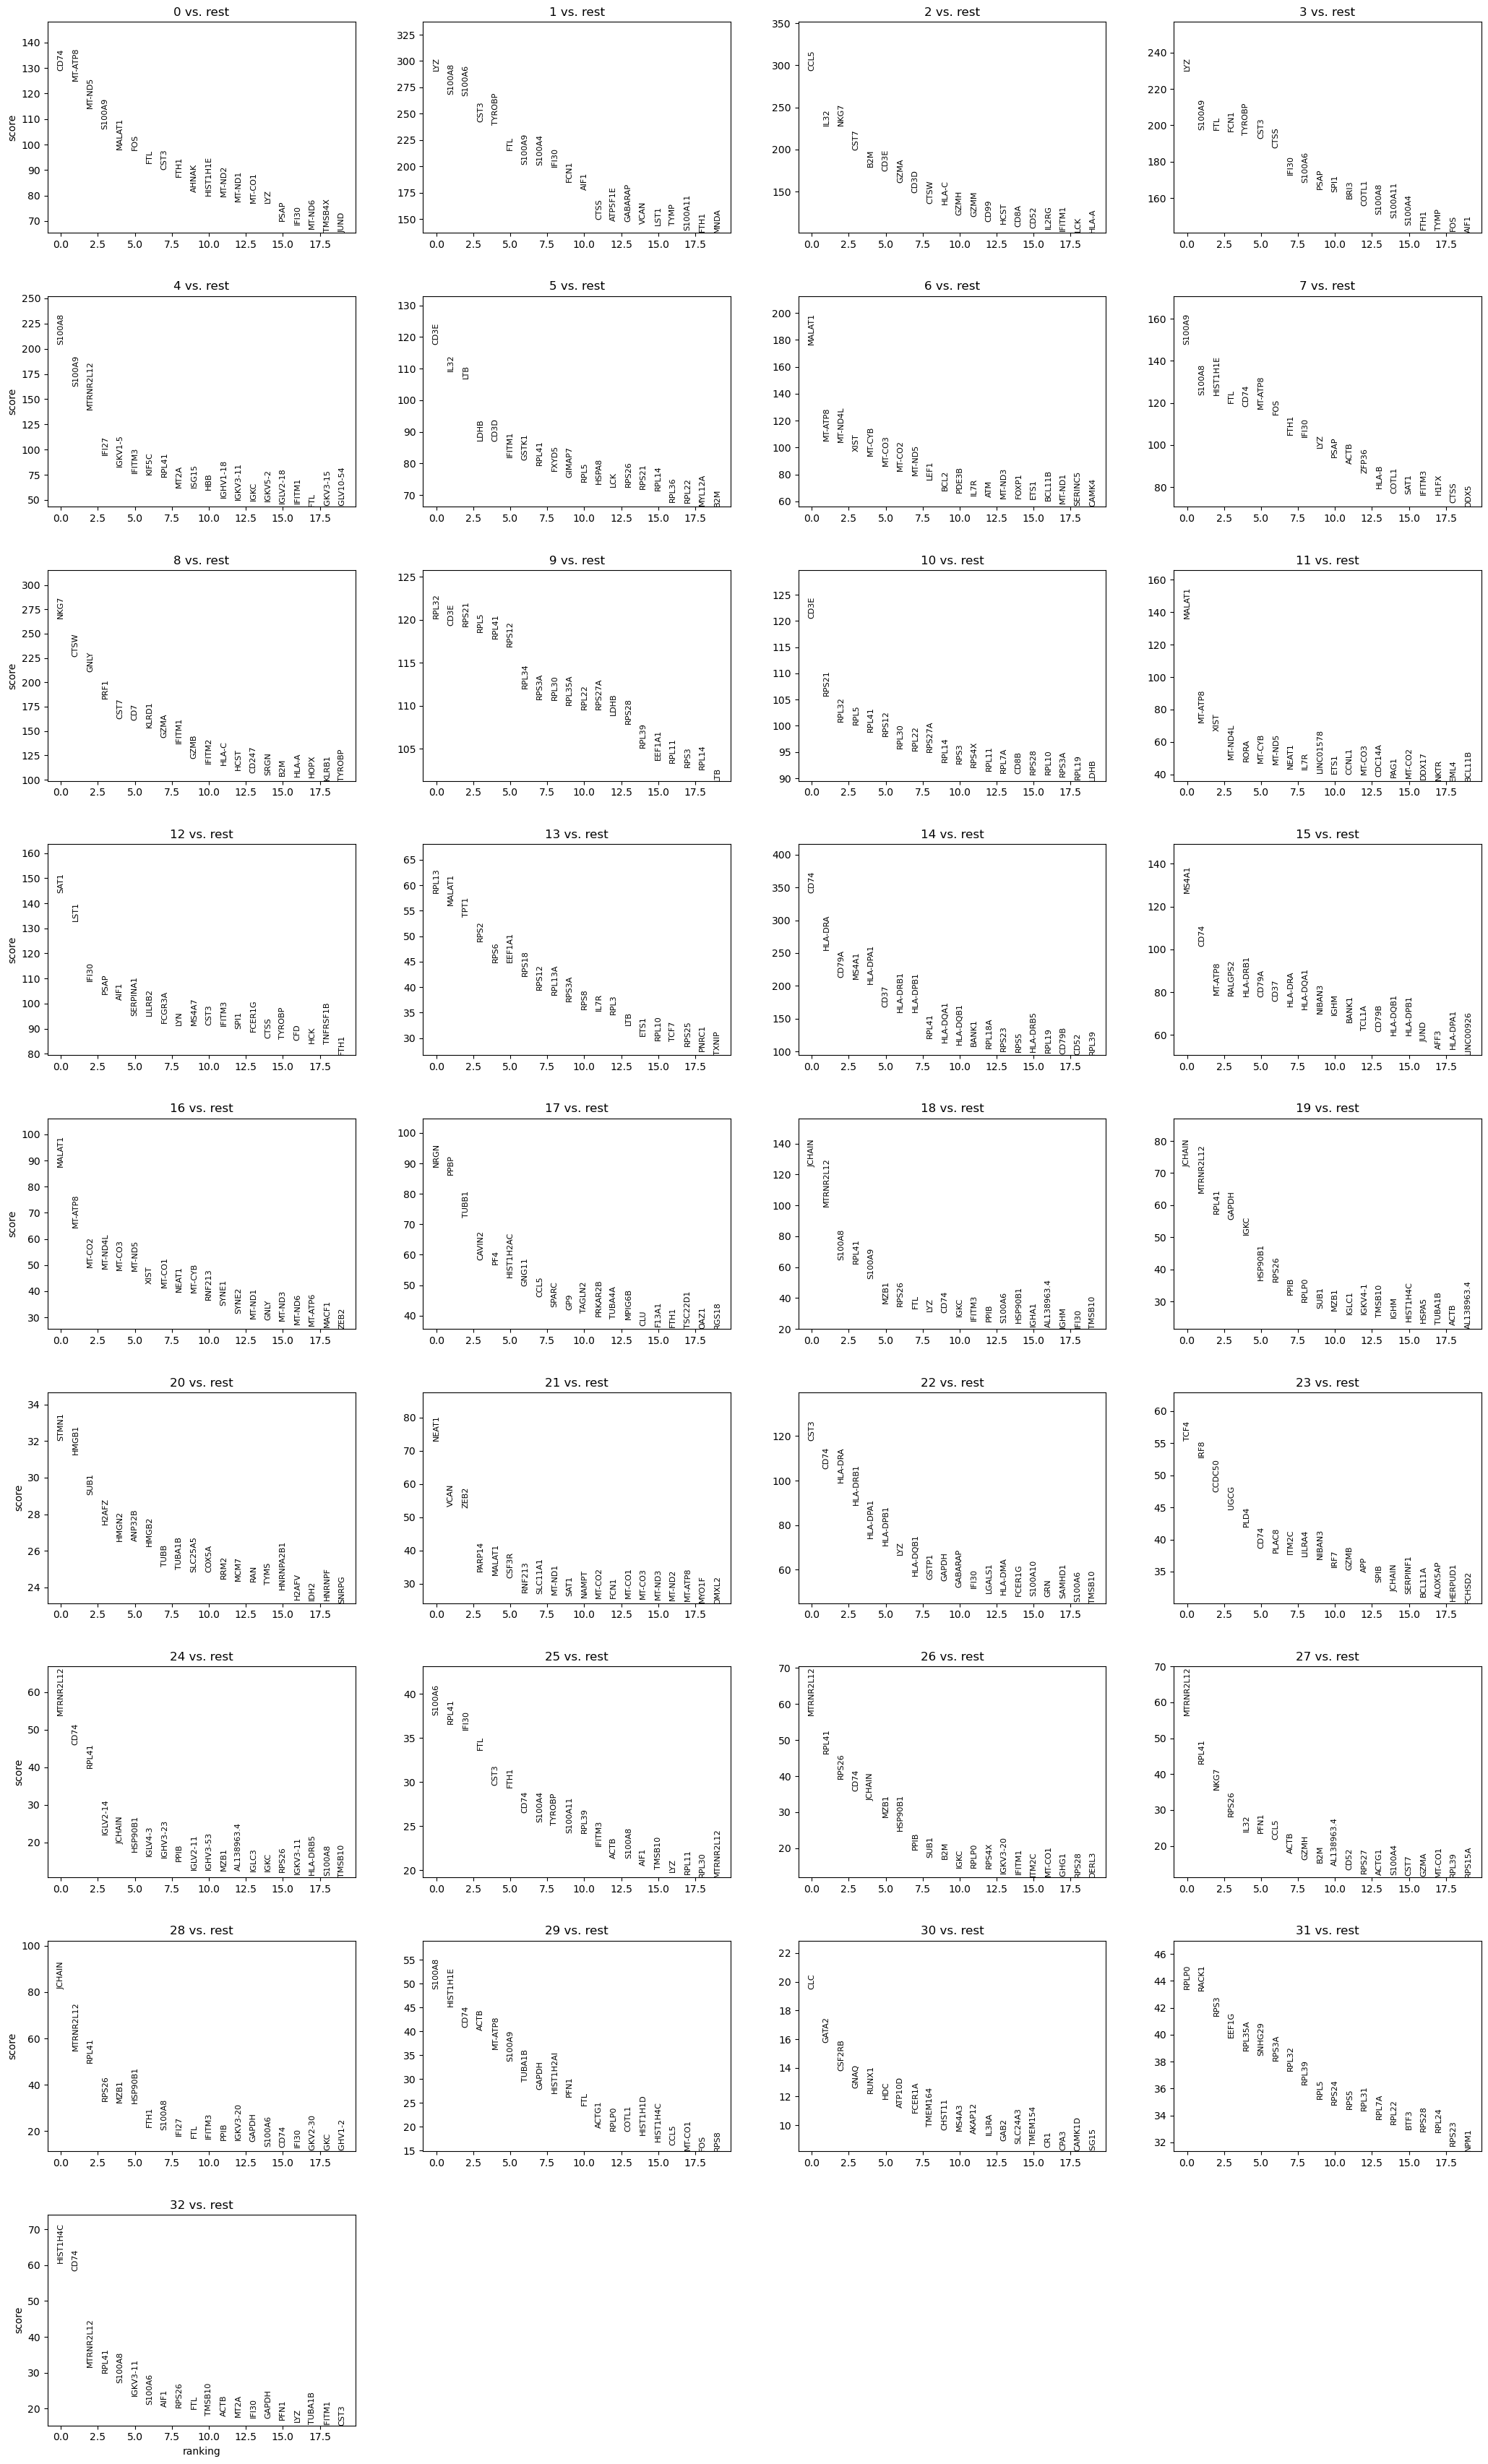

In [29]:
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [62]:
sc.tl.umap(adata)

In [11]:
adata.write_h5ad('temp.h5ad')

In [7]:
adata = sc.read_h5ad('temp.h5ad')

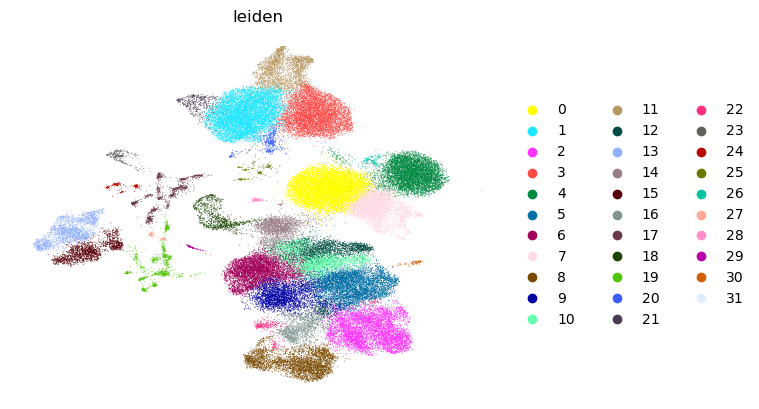

In [63]:
sc.pl.umap(adata, color=['leiden'], frameon=False)

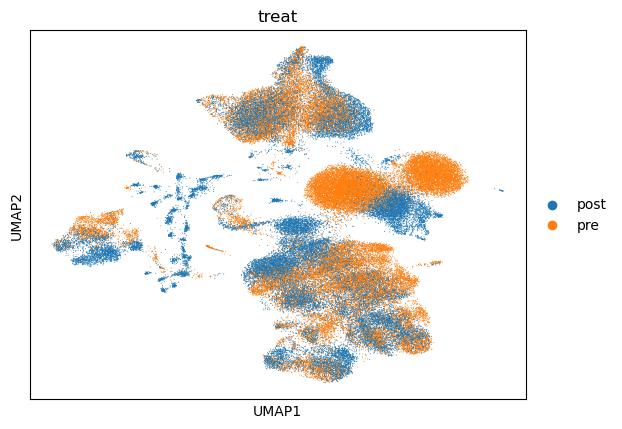

In [64]:
np.random.seed(1)
ri= np.random.permutation(list(range(adata.shape[0])))
sc.pl.umap(adata[ri, :], color=['treat'], vmin=.5, size=2)

In [65]:
markers = sc.get.rank_genes_groups_df(adata, None)
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > .5)]
markers

group     names      scores  logfoldchanges     pvals  pvals_adj
0          0      CD74  128.293686        1.777907  0.000000   0.000000
1          0   MT-ATP8  125.777367        2.440234  0.000000   0.000000
2          0    MT-ND5  113.983612        1.657327  0.000000   0.000000
3          0    S100A9  106.871964        2.160827  0.000000   0.000000
4          0       FOS   98.192390        2.282352  0.000000   0.000000
...      ...       ...         ...             ...       ...        ...
557103    31     NSMAF    2.395286        2.294523  0.028394   0.049634
557104    31     P2RX5    2.395167        2.810501  0.028401   0.049642
557105    31     HDAC2    2.395044        1.854096  0.028407   0.049647
557106    31    SAMM50    2.394598        2.187917  0.028433   0.049689
557107    31  HIST1H3G    2.392586        4.673643  0.028551   0.049890

[83850 rows x 6 columns]

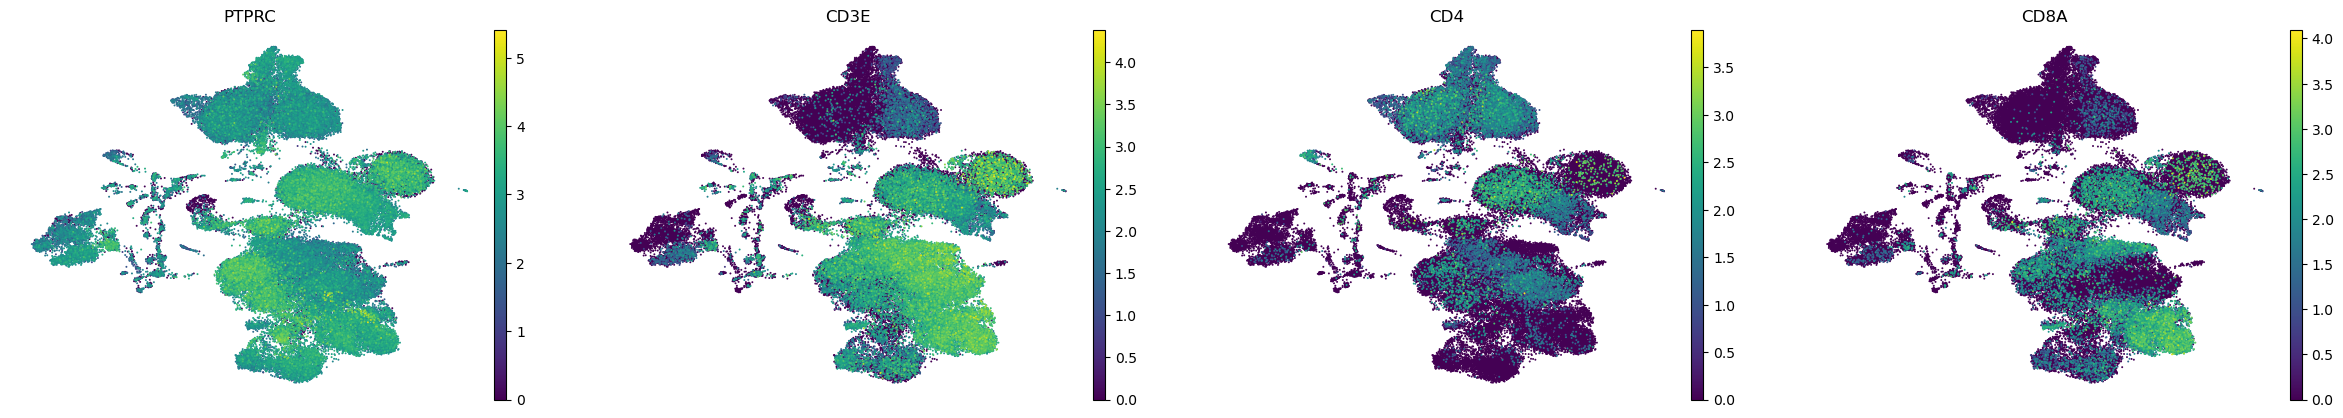

In [96]:
sc.pl.umap(adata, color=['PTPRC', 'CD3E', 'CD4', 'CD8A'], frameon=False, size=8)

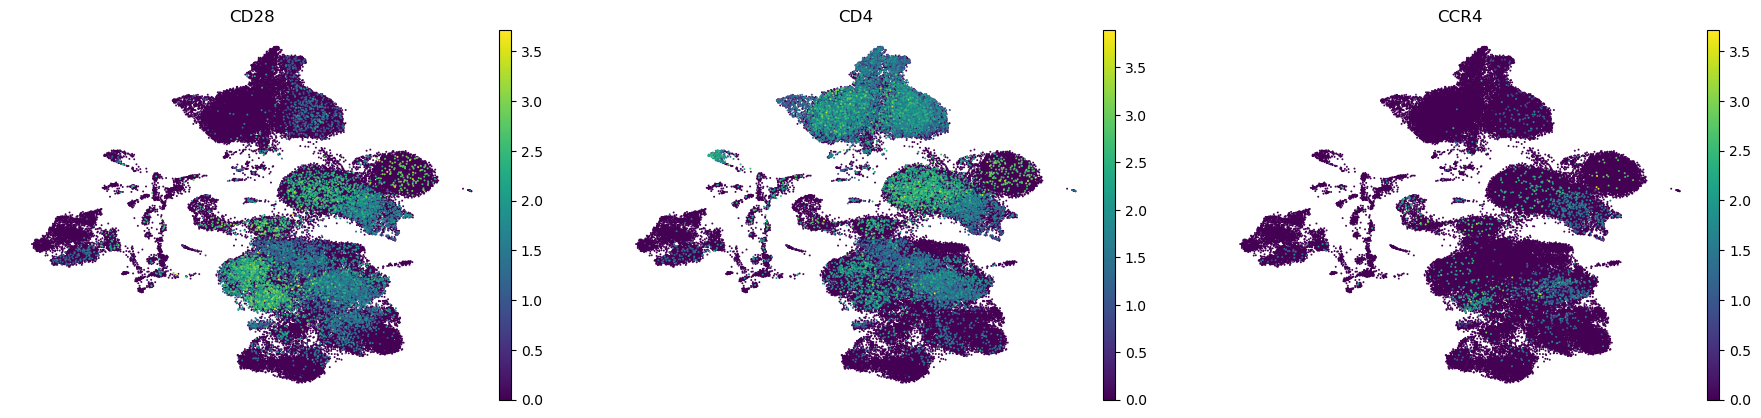

In [97]:
sc.pl.umap(adata, color=['CD28', 'CD4', 'CCR4'], frameon=False, size=8)

In [22]:
adata.obs

Patient treat     Sample  n_genes  \
AAACCTGAGCGCTCCA-1pat1_pre     pat1   pre   pat1_pre      431   
AAACCTGAGCTCCTTC-1pat1_pre     pat1   pre   pat1_pre      387   
AAACCTGAGGAGCGAG-1pat1_pre     pat1   pre   pat1_pre      474   
AAACCTGAGGCGATAC-1pat1_pre     pat1   pre   pat1_pre      388   
AAACCTGCAAGGGTCA-1pat1_pre     pat1   pre   pat1_pre      445   
...                             ...   ...        ...      ...   
TTTGTCAAGCTACCGC-1pat3_post    pat3  post  pat3_post     1793   
TTTGTCAAGGGTGTTG-1pat3_post    pat3  post  pat3_post     3702   
TTTGTCAGTCTTCAAG-1pat3_post    pat3  post  pat3_post     1702   
TTTGTCAGTTCCACTC-1pat3_post    pat3  post  pat3_post     2150   
TTTGTCATCCTTCAAT-1pat3_post    pat3  post  pat3_post     3522   

                             n_genes_by_counts  log1p_n_genes_by_counts  \
AAACCTGAGCGCTCCA-1pat1_pre                 431                 6.068426   
AAACCTGAGCTCCTTC-1pat1_pre                 387                 5.961005   
AAACCTGAGGAGCGAG-1pat1_pre                 474                 6.163315   
AAACCTGAGGCGATAC-1pat1_pre                 388                 5.963579   
AAACCTGCAAGGGTCA-1pat1_pre                 445                 6.100319   
...                                        ...                      ...   
TTTGTCAAGCTACCGC-1pat3_post               1793                 7.492203   
TTTGTCAAGGGTGTTG-1pat3_post               3702                 8.216899   
TTTGTCAGTCTTCAAG-1pat3_post               1702                 7.440147   
TTTGTCAGTTCCACTC-1pat3_post               2150                 7.673688   
TTTGTCATCCTTCAAT-1pat3_post               3522                 8.167068   

                             total_counts  log1p_total_counts  \
AAACCTGAGCGCTCCA-1pat1_pre          590.0            6.381816   
AAACCTGAGCTCCTTC-1pat1_pre          647.0            6.473891   
AAACCTGAGGAGCGAG-1pat1_pre          642.0            6.466145   
AAACCTGAGGCGATAC-1pat1_pre          526.0            6.267200   
AAACCTGCAAGGGTCA-1pat1_pre          627.0            6.442540   
...                                   ...                 ...   
TTTGTCAAGCTACCGC-1pat3_post        4674.0            8.449985   
TTTGTCAAGGGTGTTG-1pat3_post       17330.0            9.760252   
TTTGTCAGTCTTCAAG-1pat3_post        4229.0            8.349957   
TTTGTCAGTTCCACTC-1pat3_post        5202.0            8.556991   
TTTGTCATCCTTCAAT-1pat3_post       10840.0            9.291091   

                             pct_counts_in_top_20_genes  total_counts_mt  ...  \
AAACCTGAGCGCTCCA-1pat1_pre                    16.440678             12.0  ...   
AAACCTGAGCTCCTTC-1pat1_pre                    23.956723              1.0  ...   
AAACCTGAGGAGCGAG-1pat1_pre                    16.510903              9.0  ...   
AAACCTGAGGCGATAC-1pat1_pre                    18.060837              3.0  ...   
AAACCTGCAAGGGTCA-1pat1_pre                    17.384370             13.0  ...   
...                                                 ...              ...  ...   
TTTGTCAAGCTACCGC-1pat3_post                   20.496363            223.0  ...   
TTTGTCAAGGGTGTTG-1pat3_post                   17.634160            569.0  ...   
TTTGTCAGTCTTCAAG-1pat3_post                   18.562308            208.0  ...   
TTTGTCAGTTCCACTC-1pat3_post                   13.571703            162.0  ...   
TTTGTCATCCTTCAAT-1pat3_post                   16.042435            434.0  ...   

                                            immune_label  immune_score  \
AAACCTGAGCGCTCCA-1pat1_pre   Tem/Temra cytotoxic T cells      0.255952   
AAACCTGAGCTCCTTC-1pat1_pre           Classical monocytes      0.988472   
AAACCTGAGGAGCGAG-1pat1_pre   Tem/Temra cytotoxic T cells      0.848297   
AAACCTGAGGCGATAC-1pat1_pre   Tem/Effector helper T cells      0.476349   
AAACCTGCAAGGGTCA-1pat1_pre           Classical monocytes      0.421689   
...                                                  ...           ...   
TTTGTCAAGCTACCGC-1pat3_post    Tem/Trm cytotoxic T cells      0.994078   


In [66]:
adata.obs['immune_low'] = adata.obs.groupby('leiden')['immune_label'].transform(lambda x:x.mode()[0])

... storing 'immune_low' as categorical


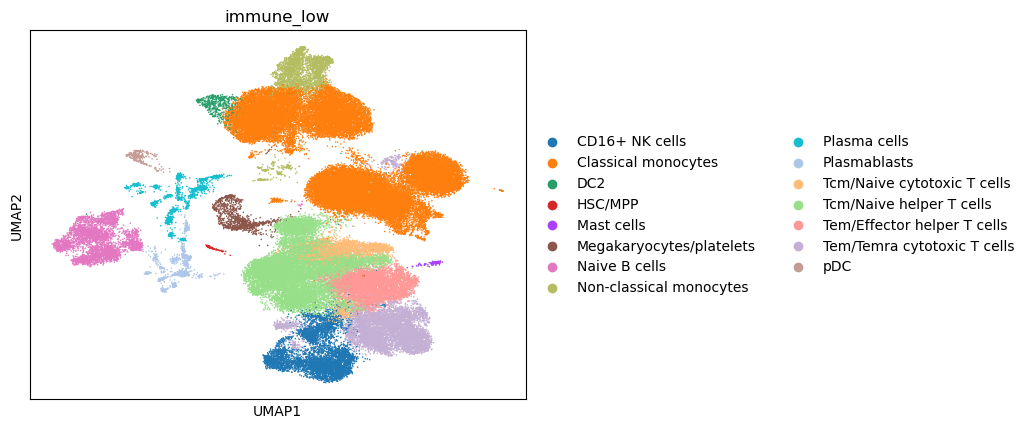

In [67]:
sc.pl.umap(adata, color = ['immune_low'], s = 5)

In [68]:
adata.obs['pbmc_healthy'] = adata.obs.groupby('leiden')['pbmc_label'].transform(lambda x:x.mode()[0])

... storing 'pbmc_healthy' as categorical


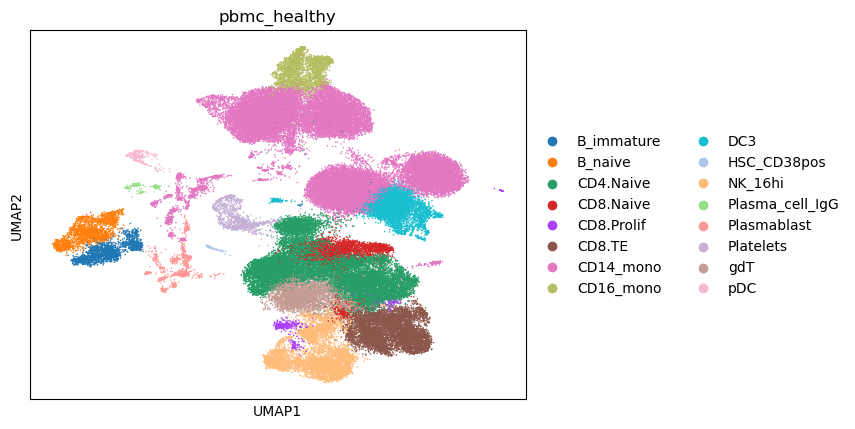

In [69]:
sc.pl.umap(adata, color = ['pbmc_healthy'], s = 5)

In [70]:
adata.obs['sle_science_ref'] = adata.obs.groupby('leiden')['ref_label'].transform(lambda x:x.mode()[0])

... storing 'sle_science_ref' as categorical


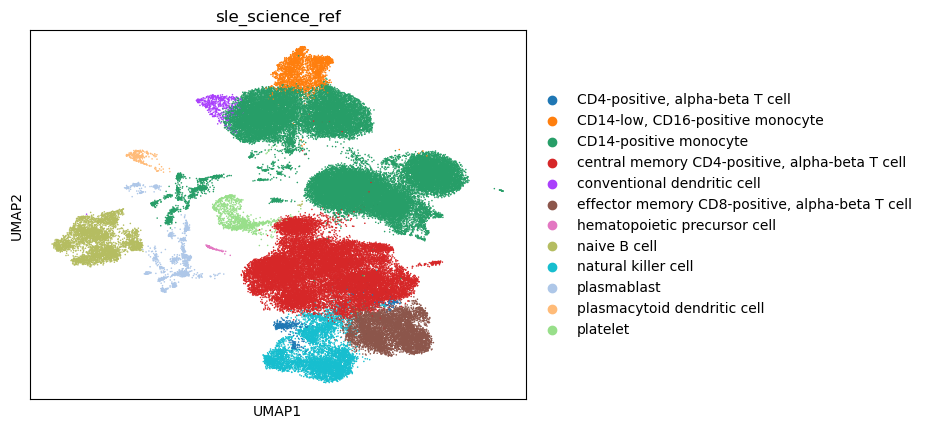

In [71]:
sc.pl.umap(adata, color = ['sle_science_ref'], s = 5)

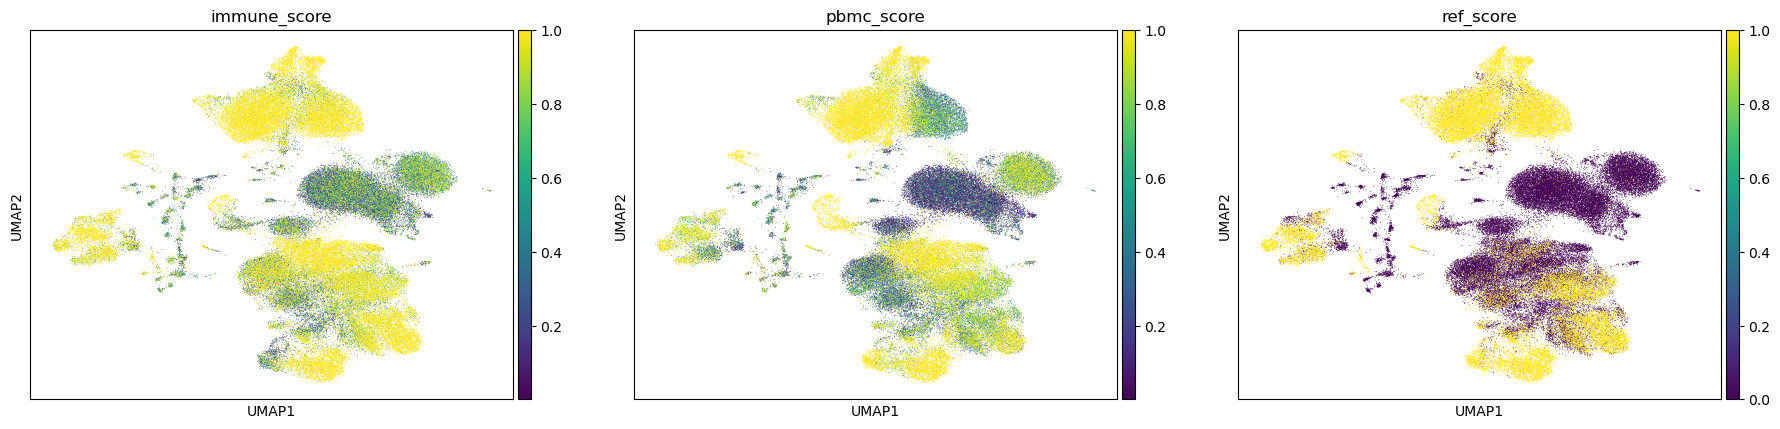

In [72]:
sc.pl.umap(adata, color = ['immune_score', 'pbmc_score', 'ref_score'], cmap='viridis')

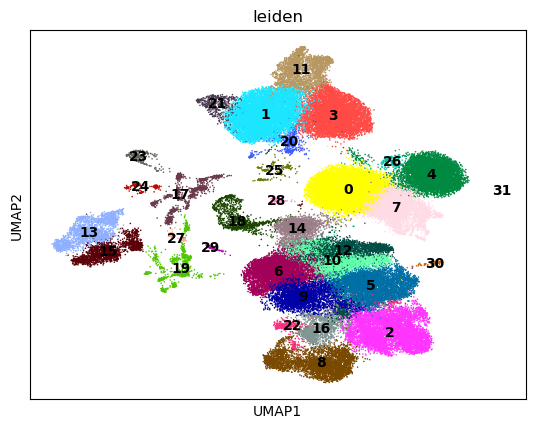

In [73]:
sc.pl.umap(adata, color=['leiden'], legend_loc='on data', s=5)

In [74]:
adata.obs

Patient treat     Sample  n_genes  \
AAACCTGAGCGCTCCA-1pat1_pre     pat1   pre   pat1_pre      431   
AAACCTGAGCTCCTTC-1pat1_pre     pat1   pre   pat1_pre      387   
AAACCTGAGGAGCGAG-1pat1_pre     pat1   pre   pat1_pre      474   
AAACCTGAGGCGATAC-1pat1_pre     pat1   pre   pat1_pre      388   
AAACCTGCAAGGGTCA-1pat1_pre     pat1   pre   pat1_pre      445   
...                             ...   ...        ...      ...   
TTTGTCAAGCTACCGC-1pat3_post    pat3  post  pat3_post     1793   
TTTGTCAAGGGTGTTG-1pat3_post    pat3  post  pat3_post     3702   
TTTGTCAGTCTTCAAG-1pat3_post    pat3  post  pat3_post     1702   
TTTGTCAGTTCCACTC-1pat3_post    pat3  post  pat3_post     2150   
TTTGTCATCCTTCAAT-1pat3_post    pat3  post  pat3_post     3522   

                             n_genes_by_counts  log1p_n_genes_by_counts  \
AAACCTGAGCGCTCCA-1pat1_pre                 431                 6.068426   
AAACCTGAGCTCCTTC-1pat1_pre                 387                 5.961005   
AAACCTGAGGAGCGAG-1pat1_pre                 474                 6.163315   
AAACCTGAGGCGATAC-1pat1_pre                 388                 5.963579   
AAACCTGCAAGGGTCA-1pat1_pre                 445                 6.100319   
...                                        ...                      ...   
TTTGTCAAGCTACCGC-1pat3_post               1793                 7.492203   
TTTGTCAAGGGTGTTG-1pat3_post               3702                 8.216899   
TTTGTCAGTCTTCAAG-1pat3_post               1702                 7.440147   
TTTGTCAGTTCCACTC-1pat3_post               2150                 7.673688   
TTTGTCATCCTTCAAT-1pat3_post               3522                 8.167068   

                             total_counts  log1p_total_counts  \
AAACCTGAGCGCTCCA-1pat1_pre          590.0            6.381816   
AAACCTGAGCTCCTTC-1pat1_pre          647.0            6.473891   
AAACCTGAGGAGCGAG-1pat1_pre          642.0            6.466145   
AAACCTGAGGCGATAC-1pat1_pre          526.0            6.267200   
AAACCTGCAAGGGTCA-1pat1_pre          627.0            6.442540   
...                                   ...                 ...   
TTTGTCAAGCTACCGC-1pat3_post        4674.0            8.449985   
TTTGTCAAGGGTGTTG-1pat3_post       17330.0            9.760252   
TTTGTCAGTCTTCAAG-1pat3_post        4229.0            8.349957   
TTTGTCAGTTCCACTC-1pat3_post        5202.0            8.556991   
TTTGTCATCCTTCAAT-1pat3_post       10840.0            9.291091   

                             pct_counts_in_top_20_genes  total_counts_mt  ...  \
AAACCTGAGCGCTCCA-1pat1_pre                    16.440678             12.0  ...   
AAACCTGAGCTCCTTC-1pat1_pre                    23.956723              1.0  ...   
AAACCTGAGGAGCGAG-1pat1_pre                    16.510903              9.0  ...   
AAACCTGAGGCGATAC-1pat1_pre                    18.060837              3.0  ...   
AAACCTGCAAGGGTCA-1pat1_pre                    17.384370             13.0  ...   
...                                                 ...              ...  ...   
TTTGTCAAGCTACCGC-1pat3_post                   20.496363            223.0  ...   
TTTGTCAAGGGTGTTG-1pat3_post                   17.634160            569.0  ...   
TTTGTCAGTCTTCAAG-1pat3_post                   18.562308            208.0  ...   
TTTGTCAGTTCCACTC-1pat3_post                   13.571703            162.0  ...   
TTTGTCATCCTTCAAT-1pat3_post                   16.042435            434.0  ...   

                                                                   ref_label  \
AAACCTGAGCGCTCCA-1pat1_pre    central memory CD4-positive, alpha-beta T cell   
AAACCTGAGCTCCTTC-1pat1_pre                            CD14-positive monocyte   
AAACCTGAGGAGCGAG-1pat1_pre                            CD14-positive monocyte   
AAACCTGAGGCGATAC-1pat1_pre                            CD14-positive monocyte   
AAACCTGCAAGGGTCA-1pat1_pre    central memory CD4-positive, alpha-beta T cell   
...                                                                      ...   
TTTGTCAAGCTACCGC-1pat3_post  eff

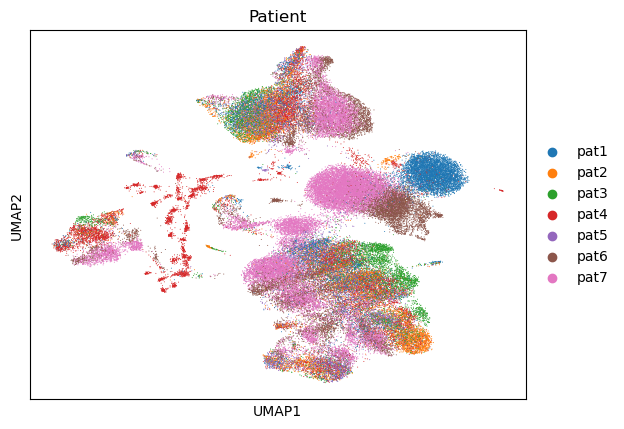

In [98]:
sc.pl.umap(adata[ri, :], color=['Patient'], vmin=.5, size=2)

In [76]:
labels = adata.obs[['immune_label', 'pbmc_label', 'ref_label', 'leiden']].groupby('leiden').agg(lambda x:x.mode())
scores = adata.obs[['immune_score', 'pbmc_score', 'ref_score', 'leiden']].groupby('leiden').agg(lambda x:x.mean())

mapping_res = labels.merge(right=scores, left_index=True, right_index=True)
mapping_res.head(61)

immune_label       pbmc_label  \
leiden                                                                       
0                                     Classical monocytes        CD14_mono   
1                                     Classical monocytes        CD14_mono   
2                             Tem/Temra cytotoxic T cells           CD8.TE   
3                                     Classical monocytes        CD14_mono   
4                                     Classical monocytes        CD14_mono   
5                             Tem/Effector helper T cells        CD4.Naive   
6                                Tcm/Naive helper T cells        CD4.Naive   
7                                     Classical monocytes              DC3   
8                                          CD16+ NK cells          NK_16hi   
9                                Tcm/Naive helper T cells              gdT   
10                               Tcm/Naive helper T cells        CD4.Naive   
11                                Non-classical monocytes        CD16_mono   
12                            Tcm/Naive cytotoxic T cells        CD8.Naive   
13                                          Naive B cells          B_naive   
14                               Tcm/Naive helper T cells        CD4.Naive   
15                                          Naive B cells       B_immature   
16                                         CD16+ NK cells          NK_16hi   
17                                           Plasma cells        CD14_mono   
18                               Megakaryocytes/platelets        Platelets   
19                                           Plasmablasts      Plasmablast   
20                                    Classical monocytes        CD14_mono   
21                                                    DC2        CD14_mono   
22                            Tem/Temra cytotoxic T cells       CD8.Prolif   
23                                                    pDC              pDC   
24                                           Plasma cells  Plasma_cell_IgG   
25                                Non-classical monocytes        CD14_mono   
26                            Tem/Temra cytotoxic T cells        CD14_mono   
27                                           Plasma cells        CD14_mono   
28                                    Classical monocytes              DC3   
29                                                HSC/MPP      HSC_CD38pos   
30                                             Mast cells        CD14_mono   
31      ['Classical monocytes', 'Proliferative germina...       CD8.Prolif   

                                              ref_label  immune_score  \
leiden                                                                  
0                                CD14-positive monocyte      0.372385   
1                                CD14-positive monocyte      0.969386   
2       effector memory CD8-positive, alpha-beta T cell      0.903911   
3                                CD14-positive monocyte      0.942124   
4                                CD14-positive monocyte      0.535523   
5        central memory CD4-positive, alpha-beta T cell      0.865293   
6        central memory CD4-positive, alpha-beta T cell      0.714107   
7                                CD14-positive monocyte      0.392301   
8                                   natural killer cell      0.844218   
9        central memory CD4-positive, alpha-beta T cell      0.568949   
10       central memory CD4-positive, alpha-beta T cell      0.963645   
11                     CD14-low, CD16-positive monocyte      0.918509   
12       central memory CD4-positive, alpha-beta T cell      0.915864   
13                                         naive B cell      0.950615   
14       central memory CD4-positive, alpha-beta T cell      0.578083   
15                                         naive B cell      0.834340   
16                                  natural killer cell      0.558339   
17   

In [33]:
sc.tl.rank_genes_groups(adata, groupby='leiden')
marks = sc.get.rank_genes_groups_df(adata, group=None)

/data/hps/assoc/private/gdml/user/yhao1/envs/singlecell/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/data/hps/assoc/private/gdml/user/yhao1/envs/singlecell/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/data/hps/assoc/private/gdml/user/yhao1/envs/singlecell/lib/python3.1

In [34]:
marks

group    names      scores  logfoldchanges  pvals  pvals_adj
0          0  MT-ATP8  127.204094        2.454537    0.0        0.0
1          0     CD74  125.166351        1.763384    0.0        0.0
2          0   MT-ND5  118.011162        1.695258    0.0        0.0
3          0   S100A9  103.712196        2.121866    0.0        0.0
4          0   MALAT1  101.012169        0.749839    0.0        0.0
...      ...      ...         ...             ...    ...        ...
538735    29    SRRM2 -249.364777      -30.572893    0.0        0.0
538736    29   S100A8 -264.479218      -32.504200    0.0        0.0
538737    29   STK17B -275.313416      -30.809690    0.0        0.0
538738    29   SMCHD1 -283.232513      -30.930071    0.0        0.0
538739    29   S100A9 -287.678375      -32.674946    0.0        0.0

[538740 rows x 6 columns]

In [35]:
marks[marks.names =='CD4'].sort_values('logfoldchanges', ascending=False).head(20)

group names     scores  logfoldchanges          pvals      pvals_adj
431151    24   CD4  13.205613        2.193475   2.034829e-32   3.751689e-31
36171      2   CD4  49.487873        1.952250   0.000000e+00   0.000000e+00
377627    21   CD4  19.652458        1.649873   1.317979e-70   2.626888e-69
18415      1   CD4  38.922771        1.480499  9.349077e-308  1.557428e-306
413384    23   CD4  11.677076        1.422837   1.858202e-27   1.960611e-26
305878    17   CD4  13.876426        1.033872   1.343044e-41   1.524550e-40
144633     8   CD4  12.348212        0.692759   2.693397e-34   1.371753e-33
644        0   CD4   5.458171        0.254189   4.919205e-08   1.224381e-07
92303      5   CD4   4.866276        0.233358   1.167400e-06   2.944407e-06
130902     7   CD4   3.559486        0.183469   3.749216e-04   8.782732e-04
455758    25   CD4  -0.468941       -0.104594   6.394278e-01   7.783397e-01
247247    13   CD4  -5.345314       -0.429750   9.873021e-08   2.723080e-07
68932      3   CD4  -9.660141       -0.474179   6.110103e-22   2.655499e-21
284061    15   CD4  -8.376064       -0.755920   9.865899e-17   5.125017e-16
411794    22   CD4  -9.243118       -1.189656   5.249512e-19   4.014938e-18
339304    18   CD4 -11.591774       -1.324290   1.056087e-29   9.458957e-29
232815    12   CD4 -21.055676       -1.388413   1.082361e-91   2.096767e-90
509685    28   CD4  -2.989394       -1.439511   3.959060e-03   6.327026e-03
376133    20   CD4 -15.057842       -1.931476   3.238264e-46   5.187578e-45
357728    19   CD4 -15.105865       -1.950527   1.010942e-46   1.070430e-45

In [77]:
for x in range(len(adata.obs.leiden.unique())):
    print(f'"{x}":"",')

"0":"",
"1":"",
"2":"",
"3":"",
"4":"",
"5":"",
"6":"",
"7":"",
"8":"",
"9":"",
"10":"",
"11":"",
"12":"",
"13":"",
"14":"",
"15":"",
"16":"",
"17":"",
"18":"",
"19":"",
"20":"",
"21":"",
"22":"",
"23":"",
"24":"",
"25":"",
"26":"",
"27":"",
"28":"",
"29":"",
"30":"",
"31":"",


In [99]:
# the_model_cpu
celltype = {
"0":"CD14 mono",
"1":"CD14 mono",
"2":"CD8 T",
"3":"CD14 mono",
"4":"CD14 mono",
"5":"CD4 T",
"6":"CD4 T",
"7":"CD14 mono",
"8":"NK",
"9":"CD4 T",
"10":"CD4 T",
"11":"CD16 mono",
"12":"CD8 T",
"13":"B naive",
"14":"CD4 T",
"15":"B naive",
"16":"NK",
"17":"CD14 mono",
"18":"Platelets",
"19":"Plasmablasts",
"20":"CD14 mono",
"21":"DC",
"22":"CD8 T",
"23":"pDC",
"24":"Plasma",
"25":"CD14 mono",
"26":"unclear",
"27":"unclear",
"28":"unclear",
"29":"unclear",
"30":"unclear",
"31":"unclear"
}

In [50]:
# using the_model
celltype = {"0":"CD14 monocytes",
"1":"CD14 monocytes",
"2":"CD14 monocytes",
"3":"CD4 T",
"4":"CD14 monocytes",
"5":"CD4 T",
"6":"CD8 T ",
"7":"CD14 monocytes",
"8":"CD4 T",
"9":"NK",
"10":"NK",
"11":"CD8 T",
"12":"CD8 T",
"13":"CD4 T",
"14":"naive B",
"15":"CD4 T",
"16":"naive B",
"17":"CD16 monocytes",
"18":"CD14 monocytes",
"19":"Platelets",
"20":"Plasmablast",
"21":"CD16 monocytes",
"22":"CD8 T",
"23":"DC",
"24":"pDC",
"25":"CD14 monocytes",
"26":"plasma cells",
"27":"unclear",
"28":"unclear",
"29":"unclear",
}


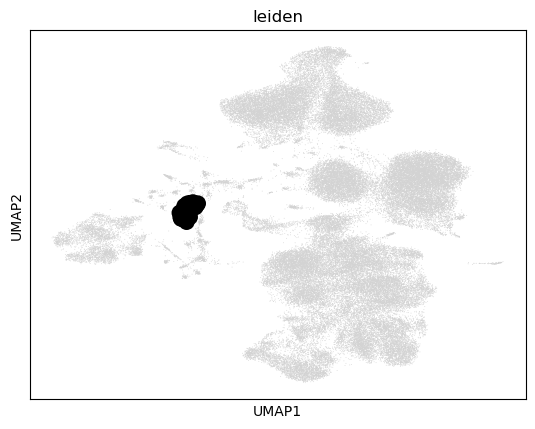

In [30]:
ax = sc.pl.umap(adata, palette='grey', show=False)
sc.pl.umap(adata[adata.obs.leiden == '24'], color='leiden', ax=ax, legend_loc=None, palette='k')

... storing 'highlight' as categorical


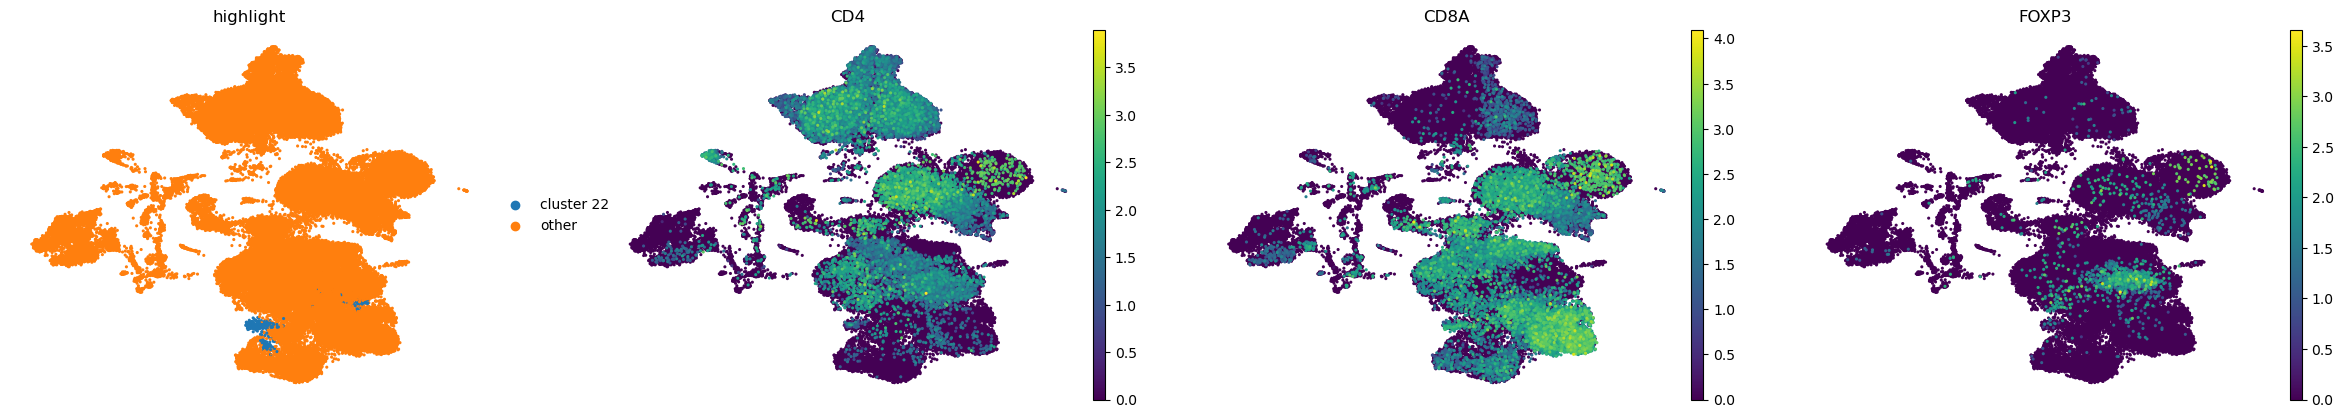

In [78]:
# Adding a new color category for highlight
adata.obs['highlight'] = ['cluster 22' if x == '22' else 'other' for x in adata.obs['leiden']]

# Plotting UMAP with new highlight and genes
sc.pl.umap(adata, color=['highlight', 'CD4', 'CD8A', 'FOXP3'], frameon=False, size=20)


In [62]:
marks[(marks.group == '7')].sort_values('logfoldchanges', ascending=False).head(50)

group       names      scores  logfoldchanges          pvals  \
125708     7      S100A8  166.121811        4.506114   0.000000e+00   
127058     7    SERPINI2   10.389005        4.325593   8.305734e-25   
127457     7      ADGRB3    8.431593        4.169297   5.529453e-17   
128101     7      DLGAP2    6.088333        4.162967   1.306744e-09   
128616     7  AC011444.3    4.789188        4.146919   1.767096e-06   
128471     7   LINC02257    5.130620        4.056055   3.097390e-07   
129162     7  AL138694.1    3.748437        4.044101   1.817543e-04   
129021     7   LINC01655    3.991421        4.020394   6.746712e-05   
126273     7       WDR49   18.067528        3.981400   6.726283e-69   
128740     7  AC011444.2    4.529292        3.858416   6.180209e-06   
125706     7         LYZ  187.485580        3.820631   0.000000e+00   
125722     7      PLXDC2   76.646576        3.778062   0.000000e+00   
125765     7       PLCB1   45.697750        3.599608   0.000000e+00   
129054     7  AC138512.1    3.925182        3.596543   8.887353e-05   
127914     7  SLC5A4-AS1    6.682726        3.550506   2.849314e-11   
125750     7       LRMDA   50.613411        3.545335   0.000000e+00   
128879     7  AC087672.2    4.249877        3.543690   2.212901e-05   
128488     7   LINC00607    5.101507        3.512336   3.608112e-07   
125709     7        CST3  146.516037        3.497287   0.000000e+00   
126085     7        NRG1   22.316660        3.421342  2.994581e-101   
125749     7      SLC8A1   51.164761        3.417541   0.000000e+00   
126772     7  AL163541.1   12.235592        3.406714   1.579475e-33   
125734     7        CSTA   62.540516        3.395304   0.000000e+00   
128728     7  AL136441.1    4.561998        3.395297   5.297116e-06   
127344     7  AL109809.5    8.923373        3.388265   8.249150e-19   
127570     7     HORMAD1    7.924414        3.372975   3.345088e-15   
126544     7  AC011472.2   14.348629        3.351990   5.035331e-45   
128305     7  AC114781.2    5.501872        3.351080   4.117324e-08   
129032     7  AC024270.5    3.966016        3.334222   7.502182e-05   
125713     7      S100A9  110.816040        3.331322   0.000000e+00   
128454     7  AC092746.1    5.182186        3.329347   2.357377e-07   
127765     7  AC109927.1    7.189382        3.325251   8.427744e-13   
125755     7       RBM47   48.889030        3.320124   0.000000e+00   
127639     7  AL078604.4    7.629555        3.270260   3.262191e-14   
127581     7  AL031123.1    7.838104        3.269540   6.564978e-15   
126166     7     CCDC200   20.344471        3.249998   1.270508e-85   
125710     7      TYROBP  144.437637        3.248306   0.000000e+00   
128608     7      SPOCK3    4.803852        3.234520   1.643092e-06   
127530     7  AL450992.3    8.097413        3.233938   8.470068e-16   
126461     7       LPAR1   15.269181        3.225700   1.616317e-50   
129217     7  AC008114.1    3.666063        3.222600   2.511487e-04   
129208     7  AC005071.1    3.676984        3.185198   2.406880e-04   
125819     7       MAML3   36.016201        3.172703  6.034755e-232   
126937     7  AC009226.1   11.175491        3.152963   2.286755e-28   
125716     7        FCN1   98.104454        3.149061   0.000000e+00   
127561     7  AP000282.1    7.943494        3.148669   2.876805e-15   
125720     7        VCAN   86.548378        3.134093   0.000000e+00   
129393     7  AC090115.1    3.381339        3.130323   7.317776e-04   
128396     7       TEX41    5.319482        3.128674   1.127427e-07   
127503     7  AC005392.2    8.210210        3.124182   3.406205e-16   

            pvals_adj  
125708   0.000000e+00  
127058   3.547915e-24  
127457   1.819977e-16  
128101   3.132626e-09  
128616   3.623374e-06  
128471   6.618625e-07  
129162   3.236113e-04  
129021   1.241240e-04  
126273   6.418203e-68  
128740   1.224315e-05  
125706   0.000000e+00  
125722   0.000000e+00  
125765   0.000000e+00  
129054   1.621777e-04  
127914   7.330657e-11  
1

In [100]:
adata.obs['celltype'] = adata.obs.leiden.map(celltype)

... storing 'celltype' as categorical


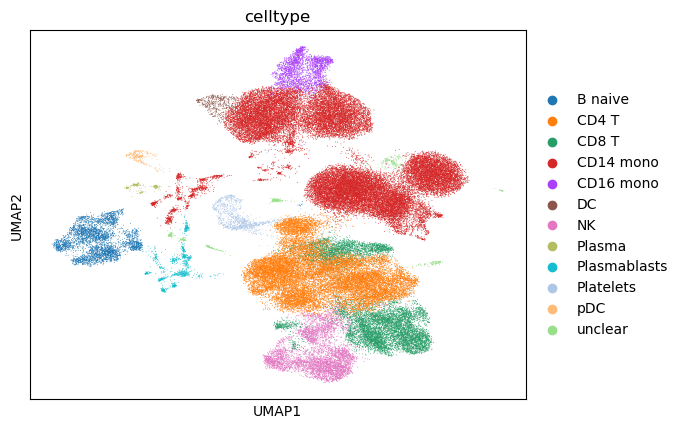

In [101]:
sc.pl.umap(adata, color=['celltype'])

In [82]:
adata.uns['markers'] = marks

In [83]:
adata.write_h5ad('integrated.h5ad')

In [29]:
model.save('model.model')

ValueError: model.model already exists. Please provide another directory for saving.

Analysis

counting cells

In [30]:
adata = sc.read_h5ad('integrated.h5ad')

In [3]:
adata.obs

Patient treat     Sample  n_genes  \
AAACCTGAGTGAACAT-1pat6_post    pat6  post  pat6_post     2679   
AAACCTGCAAGCCATT-1pat6_post    pat6  post  pat6_post     1698   
AAACCTGCAATAGCGG-1pat6_post    pat6  post  pat6_post     1920   
AAACCTGCACATAACC-1pat6_post    pat6  post  pat6_post     1624   
AAACCTGCACGGTTTA-1pat6_post    pat6  post  pat6_post     2469   
...                             ...   ...        ...      ...   
TTTGTCAGTTGCTCCT-1pat3_pre     pat3   pre   pat3_pre      519   
TTTGTCATCAAACGGG-1pat3_pre     pat3   pre   pat3_pre     1259   
TTTGTCATCAACGAAA-1pat3_pre     pat3   pre   pat3_pre      618   
TTTGTCATCCAAAGTC-1pat3_pre     pat3   pre   pat3_pre      723   
TTTGTCATCTCGATGA-1pat3_pre     pat3   pre   pat3_pre     1537   

                             n_genes_by_counts  log1p_n_genes_by_counts  \
AAACCTGAGTGAACAT-1pat6_post               2679                 7.893572   
AAACCTGCAAGCCATT-1pat6_post               1698                 7.437795   
AAACCTGCAATAGCGG-1pat6_post               1920                 7.560601   
AAACCTGCACATAACC-1pat6_post               1624                 7.393263   
AAACCTGCACGGTTTA-1pat6_post               2469                 7.811973   
...                                        ...                      ...   
TTTGTCAGTTGCTCCT-1pat3_pre                 519                 6.253829   
TTTGTCATCAAACGGG-1pat3_pre                1259                 7.138867   
TTTGTCATCAACGAAA-1pat3_pre                 618                 6.428105   
TTTGTCATCCAAAGTC-1pat3_pre                 723                 6.584791   
TTTGTCATCTCGATGA-1pat3_pre                1537                 7.338238   

                             total_counts  log1p_total_counts  \
AAACCTGAGTGAACAT-1pat6_post        7591.0            8.934851   
AAACCTGCAAGCCATT-1pat6_post        3314.0            8.106213   
AAACCTGCAATAGCGG-1pat6_post        3735.0            8.225771   
AAACCTGCACATAACC-1pat6_post        3138.0            8.051660   
AAACCTGCACGGTTTA-1pat6_post        6919.0            8.842171   
...                                   ...                 ...   
TTTGTCAGTTGCTCCT-1pat3_pre         1016.0            6.924613   
TTTGTCATCAAACGGG-1pat3_pre         3105.0            8.041091   
TTTGTCATCAACGAAA-1pat3_pre         1066.0            6.972606   
TTTGTCATCCAAAGTC-1pat3_pre         1501.0            7.314553   
TTTGTCATCTCGATGA-1pat3_pre         3887.0            8.265650   

                             pct_counts_in_top_20_genes  total_counts_mt  ...  \
AAACCTGAGTGAACAT-1pat6_post                   15.663285            274.0  ...   
AAACCTGCAAGCCATT-1pat6_post                   14.484007            126.0  ...   
AAACCTGCAATAGCGG-1pat6_post                   14.966533            113.0  ...   
AAACCTGCACATAACC-1pat6_post                   15.487572            117.0  ...   
AAACCTGCACGGTTTA-1pat6_post                   16.591993            204.0  ...   
...                                                 ...              ...  ...   
TTTGTCAGTTGCTCCT-1pat3_pre                    25.984252             22.0  ...   
TTTGTCATCAAACGGG-1pat3_pre                    22.318841             40.0  ...   
TTTGTCATCAACGAAA-1pat3_pre                    20.075047             15.0  ...   
TTTGTCATCCAAAGTC-1pat3_pre                    29.113924             27.0  ...   
TTTGTCATCTCGATGA-1pat3_pre                    23.565732            146.0  ...   

                             doublet  doublet_score          low_immune_label  \
AAACCTGAGTGAACAT-1pat6_post      0.0   3.924602e-16       Classical monocytes   
AAACCTGCAAGCCATT-1pat6_post      0.0   3.279356e-06   Non-classical monocytes   
AAACCTGCAATAGCGG-1pat6_post      0.0   7.878154e-01       Classical monocytes   
AAACCTGCACATAACC-1pat6_post      0.0   9.430998e-12                      ILC3   
AAACCTGCACGGTTTA-1pat6_post      0.0   6.671722e-02       Classical monocytes   
...                              ...            ...                       ...   
TTTGTCAGTTGCTCCT-1pat3_pr

{'pat1_post': 3330,
 'pat1_pre': 6485,
 'pat2_post': 2070,
 'pat2_pre': 5155,
 'pat3_post': 1683,
 'pat3_pre': 4829,
 'pat4_post': 4337,
 'pat4_pre': 5683,
 'pat5_post': 5974,
 'pat5_pre': 375,
 'pat6_post': 8163,
 'pat6_pre': 4809,
 'pat7_post': 11078,
 'pat7_pre': 14156}

this is absolute cell counts, which is not normalized, should not use it. 

In [84]:
num_total_cells_celltype = adata.obs.groupby(['treat', 'celltype']).count()
num_total_cells_celltype = num_total_cells_celltype[num_total_cells_celltype.columns[0]]
num_total_cells_celltype

treat  celltype    
post   B naive          2309
       CD4 T           10301
       CD8 T            4385
       CD14 mono       12470
       CD16 mono        1434
       CD mono           506
       DC                192
       NK               2977
       Plasma            170
       Plasmablasts      829
       Platelets         465
       pDC               196
       unclear           401
pre    B naive          1439
       CD4 T            8895
       CD8 T            4716
       CD14 mono       13157
       CD16 mono        1056
       CD mono          8679
       DC                265
       NK               2355
       Plasma             38
       Plasmablasts      103
       Platelets         521
       pDC                59
       unclear           209
Name: Patient, dtype: int64

In [85]:
pivot_df = pd.DataFrame(num_total_cells_celltype)
#pivot_df.index

pivot_df = pivot_df.unstack(level=0)['Patient']

pivot_df['post/pre_ratio'] = pivot_df['post']/pivot_df['pre']
pivot_df

treat          post    pre  post/pre_ratio
celltype                                  
B naive        2309   1439        1.604587
CD4 T         10301   8895        1.158066
CD8 T          4385   4716        0.929813
CD14 mono     12470  13157        0.947784
CD16 mono      1434   1056        1.357955
CD mono         506   8679        0.058302
DC              192    265        0.724528
NK             2977   2355        1.264119
Plasma          170     38        4.473684
Plasmablasts    829    103        8.048544
Platelets       465    521        0.892514
pDC             196     59        3.322034
unclear         401    209        1.918660

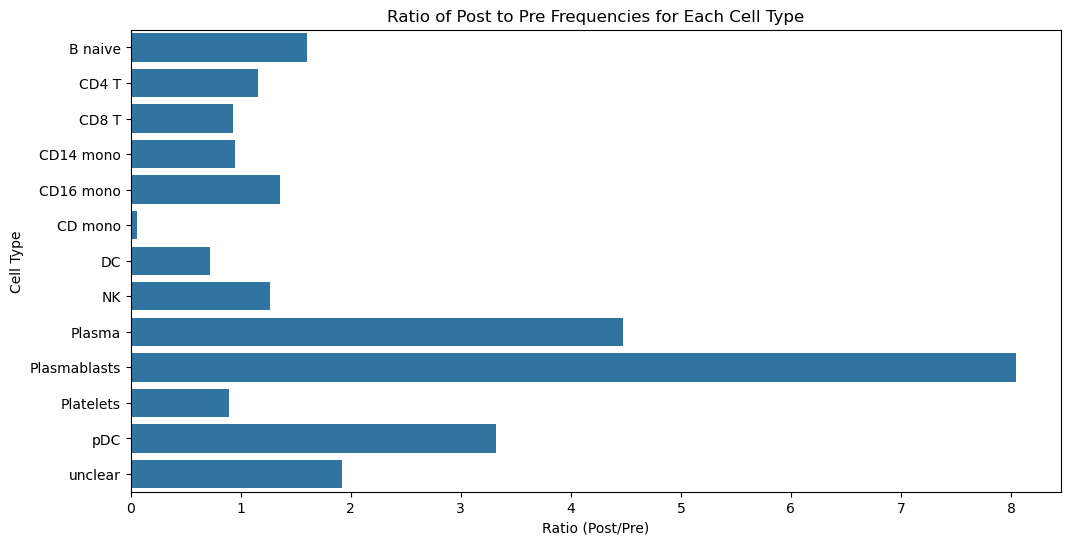

In [86]:
# Reset the index for plotting
pivot_df = pivot_df.reset_index()

# Plot the ratio
plt.figure(figsize=(12, 6))
sns.barplot(x='post/pre_ratio', y='celltype', data=pivot_df, palette=None)
plt.xlabel('Ratio (Post/Pre)')
plt.ylabel('Cell Type')
plt.title('Ratio of Post to Pre Frequencies for Each Cell Type')
plt.show()

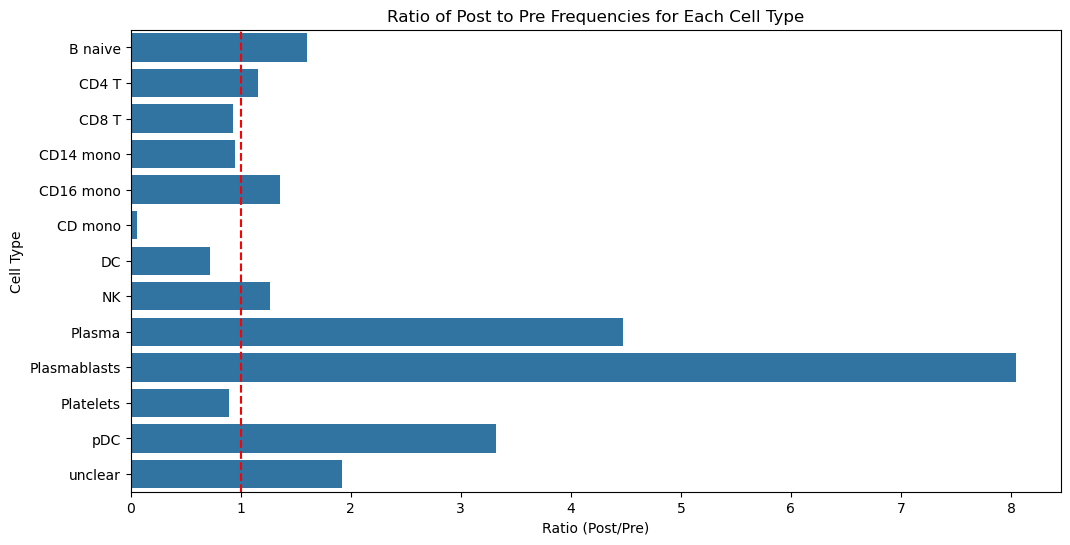

In [87]:
# Filter out the unwanted cell types
pivot_df_2 = pivot_df[~pivot_df['celltype'].isin(['plasma cells', 'plasmablasts'])]

# Plot the ratio
plt.figure(figsize=(12, 6))
sns.barplot(x='post/pre_ratio', y='celltype', data=pivot_df_2, palette=None)
plt.axvline(x=1, color='red', linestyle='--', label='Ratio = 1')  # Add vertical line
plt.xlabel('Ratio (Post/Pre)')
plt.ylabel('Cell Type')
plt.title('Ratio of Post to Pre Frequencies for Each Cell Type')
plt.show()

In [88]:
cell_type_counts = adata.obs.groupby(['Sample', 'treat', 'celltype']).count()
cell_type_counts = cell_type_counts[cell_type_counts.sum(axis=1)>0].reset_index()
cell_type_counts = cell_type_counts[cell_type_counts.columns[0:4]]
cell_type_counts

Sample treat      celltype  Patient
0    pat1_post  post       B naive      130
1    pat1_post  post         CD4 T     1178
2    pat1_post  post         CD8 T      581
3    pat1_post  post     CD14 mono      943
4    pat1_post  post     CD16 mono      165
..         ...   ...           ...      ...
156   pat7_pre   pre            NK      285
157   pat7_pre   pre  Plasmablasts        4
158   pat7_pre   pre     Platelets      246
159   pat7_pre   pre           pDC        2
160   pat7_pre   pre       unclear        3

[161 rows x 4 columns]

In [89]:
num_total_cells = adata.obs.groupby(['Sample']).count()
num_total_cells = dict(zip(num_total_cells.index, num_total_cells.Patient))
num_total_cells

{'pat1_post': 3330,
 'pat1_pre': 6485,
 'pat2_post': 2070,
 'pat2_pre': 5155,
 'pat3_post': 1683,
 'pat3_pre': 4829,
 'pat4_post': 4337,
 'pat4_pre': 5683,
 'pat5_post': 5974,
 'pat5_pre': 375,
 'pat6_post': 8163,
 'pat6_pre': 4809,
 'pat7_post': 11078,
 'pat7_pre': 14156}

In [90]:
cell_type_counts['total_cells'] = cell_type_counts.Sample.map(num_total_cells).astype(int)
cell_type_counts['frequency'] = cell_type_counts.Patient/cell_type_counts.total_cells
cell_type_counts

Sample treat      celltype  Patient  total_cells  frequency
0    pat1_post  post       B naive      130         3330   0.039039
1    pat1_post  post         CD4 T     1178         3330   0.353754
2    pat1_post  post         CD8 T      581         3330   0.174474
3    pat1_post  post     CD14 mono      943         3330   0.283183
4    pat1_post  post     CD16 mono      165         3330   0.049550
..         ...   ...           ...      ...          ...        ...
156   pat7_pre   pre            NK      285        14156   0.020133
157   pat7_pre   pre  Plasmablasts        4        14156   0.000283
158   pat7_pre   pre     Platelets      246        14156   0.017378
159   pat7_pre   pre           pDC        2        14156   0.000141
160   pat7_pre   pre       unclear        3        14156   0.000212

[161 rows x 6 columns]

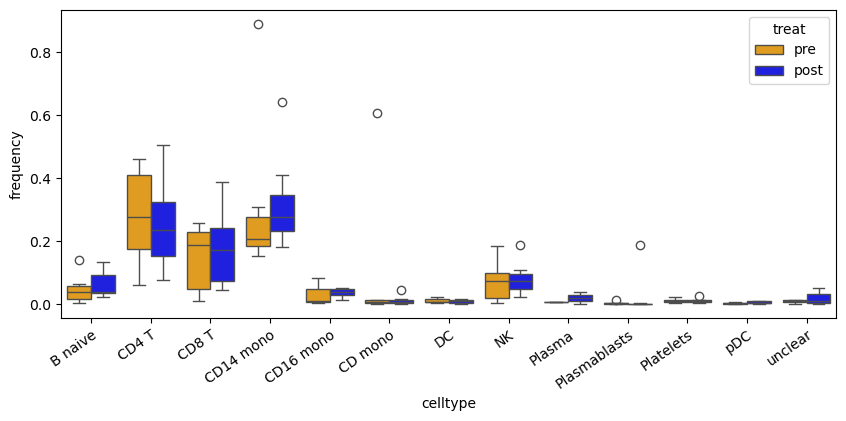

In [91]:
# Reorder the 'treat' column
cell_type_counts['treat'] = pd.Categorical(cell_type_counts['treat'], categories=['pre', 'post'], ordered=True)

# Define a custom color palette
custom_palette = {'pre': 'orange', 'post': 'blue'}


plt.figure(figsize = (10,4))

ax = sns.boxplot(data = cell_type_counts, x = 'celltype', y = 'frequency', hue = 'treat', palette=custom_palette)

plt.xticks(rotation = 35, rotation_mode = 'anchor', ha = 'right')

plt.show()

Diff Expression

In [56]:
model = scvi.model.SCVI.load('model.model', adata)

INFO     File model.model/model.pt already downloaded                                                              


In [57]:
model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Trained
Model's adata is minified?: False

In [65]:
scvi_de = model.differential_expression(
    idx1 = [adata.obs['treat'] == 'post'], 
    idx2 = [adata.obs['treat'] == 'pre']
)

DE...: 100%|██████████| 1/1 [04:18<00:00, 258.90s/it]


In [66]:
scvi_de

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
TMEM176B    0.9598        0.0402      3.172858  0.000084  0.000049   
CDKN1C      0.9580        0.0420      3.127178  0.000059  0.000035   
CCL8        0.9580        0.0420      3.127178  0.000007  0.000011   
IL1B        0.9580        0.0420      3.127178  0.000027  0.000022   
CXCL8       0.9574        0.0426      3.112367  0.000032  0.000017   
...            ...           ...           ...       ...       ...   
BFAR        0.4294        0.5706     -0.284300  0.000051  0.000049   
SYF2        0.4264        0.5736     -0.296554  0.000142  0.000136   
PRPF6       0.4090        0.5910     -0.368101  0.000090  0.000089   
BECN1       0.4050        0.5950     -0.384674  0.000061  0.000059   
ZC3H15      0.3662        0.6338     -0.548554  0.000118  0.000117   

          pseudocounts  delta  lfc_mean  lfc_median   lfc_std    lfc_min  \
TMEM176B           0.0   0.25  0.155709    0.275332  4.274282 -10.114424   
CDKN1C             0.0   0.25 -0.247671   -0.353960  4.300057 -13.058164   
CCL8               0.0   0.25 -0.763038   -0.819185  4.472744 -11.941270   
IL1B               0.0   0.25  0.405840    0.447365  4.365328 -13.086440   
CXCL8              0.0   0.25  0.366933    0.391315  4.261477 -11.501062   
...                ...    ...       ...         ...       ...        ...   
BFAR               0.0   0.25  0.077990    0.049612  0.367936  -2.159757   
SYF2               0.0   0.25  0.065085    0.076880  0.336328  -3.065624   
PRPF6              0.0   0.25  0.009277    0.003854  0.332101  -3.260317   
BECN1              0.0   0.25  0.043321    0.053262  0.302188  -2.176466   
ZC3H15             0.0   0.25  0.013968    0.031733  0.363553  -4.039218   

            lfc_max  raw_mean1  raw_mean2  non_zeros_proportion1  \
TMEM176B  11.723351   0.456820   0.115060               0.179992   
CDKN1C    14.745801   0.337632   0.069050               0.079405   
CCL8      11.943365   0.007343   0.008797               0.003740   
IL1B      12.835920   0.119968   0.071195               0.066412   
CXCL8     13.319038   0.081480   0.010315               0.043265   
...             ...        ...        ...                    ...   
BFAR       2.058354   0.184450   0.111785               0.159356   
SYF2       1.972679   0.555272   0.345543               0.385942   
PRPF6      2.529949   0.314827   0.202634               0.251726   
BECN1      1.357783   0.235880   0.147403               0.200628   
ZC3H15     3.827805   0.490548   0.314451               0.355016   

          non_zeros_proportion2  raw_normalized_mean1  raw_normalized_mean2  \
TMEM176B               0.057071              0.972836              0.343955   
CDKN1C                 0.034922              0.591798              0.270647   
CCL8                   0.004965              0.020737              0.059851   
IL1B                   0.032103              0.269028              0.209239   
CXCL8                  0.007592              0.192545              0.049541   
...                         ...                   ...                   ...   
BFAR                   0.100164              0.474439              0.434929   
SYF2                   0.261785              1.424063              1.376298   
PRPF6                  0.170033              0.843564              0.828480   
BECN1                  0.130507              0.626650              0.619733   
ZC3H15                 0.244360              1.273234              1.293225   

          is_de_fdr_0.05  
TMEM176B            True  
CDKN1C              True  
CCL8                True  
IL1B                True  
CXCL8               True  
...                  ...  
BFAR               False  
SYF2               False  
PRPF6              False  
BECN1              False  
ZC3H15             False  

[17958 rows x 19 columns]

In [69]:
scvi_de_filter = scvi_de[(scvi_de['is_de_fdr_0.05'])]
scvi_de_filter = scvi_de_filter.sort_values('lfc_mean')
scvi_de_filter

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
ADAMTS2     0.9476        0.0524      2.895026  0.000002  0.000012   
CXCL10      0.9488        0.0512      2.919458  0.000016  0.000047   
CXCL11      0.9534        0.0466      3.018434  0.000004  0.000012   
SLC1A3      0.9474        0.0526      2.891005  0.000003  0.000015   
IL1R2       0.9556        0.0444      3.069100  0.000007  0.000040   
...            ...           ...           ...       ...       ...   
TRBV11-3    0.9490        0.0510      2.923583  0.000012  0.000009   
IGHV3-66    0.9508        0.0492      2.961410  0.000027  0.000010   
PTGS2       0.9476        0.0524      2.895026  0.000007  0.000005   
IGKV1D-8    0.9458        0.0542      2.859350  0.000013  0.000005   
IGLV2-23    0.9498        0.0502      2.940236  0.000138  0.000044   

          pseudocounts  delta  lfc_mean  lfc_median   lfc_std    lfc_min  \
ADAMTS2            0.0   0.25 -1.641568   -1.671011  3.658005 -12.155528   
CXCL10             0.0   0.25 -1.544460   -1.573218  3.191432 -12.862610   
CXCL11             0.0   0.25 -1.487251   -1.591078  3.661989 -12.746081   
SLC1A3             0.0   0.25 -1.412032   -1.439050  3.692179 -11.700971   
IL1R2              0.0   0.25 -1.287798   -1.187072  3.793696 -11.150688   
...                ...    ...       ...         ...       ...        ...   
TRBV11-3           0.0   0.25  0.546481    0.560413  3.864639 -10.184985   
IGHV3-66           0.0   0.25  0.632849    0.658293  3.642035 -12.460340   
PTGS2              0.0   0.25  0.644467    0.598342  3.428773 -10.109112   
IGKV1D-8           0.0   0.25  0.840837    0.873199  3.407617 -10.723980   
IGLV2-23           0.0   0.25  1.050968    1.246202  3.188161 -10.809350   

            lfc_max  raw_mean1  raw_mean2  non_zeros_proportion1  \
ADAMTS2   10.494685   0.000437   0.019064               0.000437   
CXCL10     9.636053   0.024812   0.059963               0.010291   
CXCL11    10.648496   0.001938   0.005254               0.000737   
SLC1A3     9.717731   0.003931   0.026559               0.003767   
IL1R2      8.706731   0.005623   0.048034               0.004668   
...             ...        ...        ...                    ...   
TRBV11-3  10.873952   0.023830   0.005471               0.009062   
IGHV3-66  11.795372   0.022083   0.002193               0.010973   
PTGS2     10.892818   0.038269   0.017835               0.027788   
IGKV1D-8  11.829345   0.023038   0.007688               0.006578   
IGLV2-23  10.426991   0.294287   0.079823               0.056094   

          non_zeros_proportion2  raw_normalized_mean1  raw_normalized_mean2  \
ADAMTS2                0.015208              0.001131              0.083302   
CXCL10                 0.022221              0.056239              0.338380   
CXCL11                 0.002989              0.003233              0.042731   
SLC1A3                 0.016871              0.009528              0.111778   
IL1R2                  0.026969              0.013400              0.339567   
...                         ...                   ...                   ...   
TRBV11-3               0.002386              0.061501              0.021501   
IGHV3-66               0.000554              0.075318              0.009808   
PTGS2                  0.012798              0.088699              0.060051   
IGKV1D-8               0.001036              0.069603              0.027564   
IGLV2-23               0.010098              0.960547              0.235087   

          is_de_fdr_0.05  
ADAMTS2             True  
CXCL10              True  
CXCL11              True  
SLC1A3              True  
IL1R2               True  
...                  ...  
TRBV11-3            True  
IGHV3-66            True  
PTGS2               True  
IGKV1D-8            True  
IGLV2-23            True  

[76 rows x 19 columns]

In [70]:
genes_to_show = scvi_de_filter[-25:].index.tolist() + scvi_de_filter[:25].index.tolist()

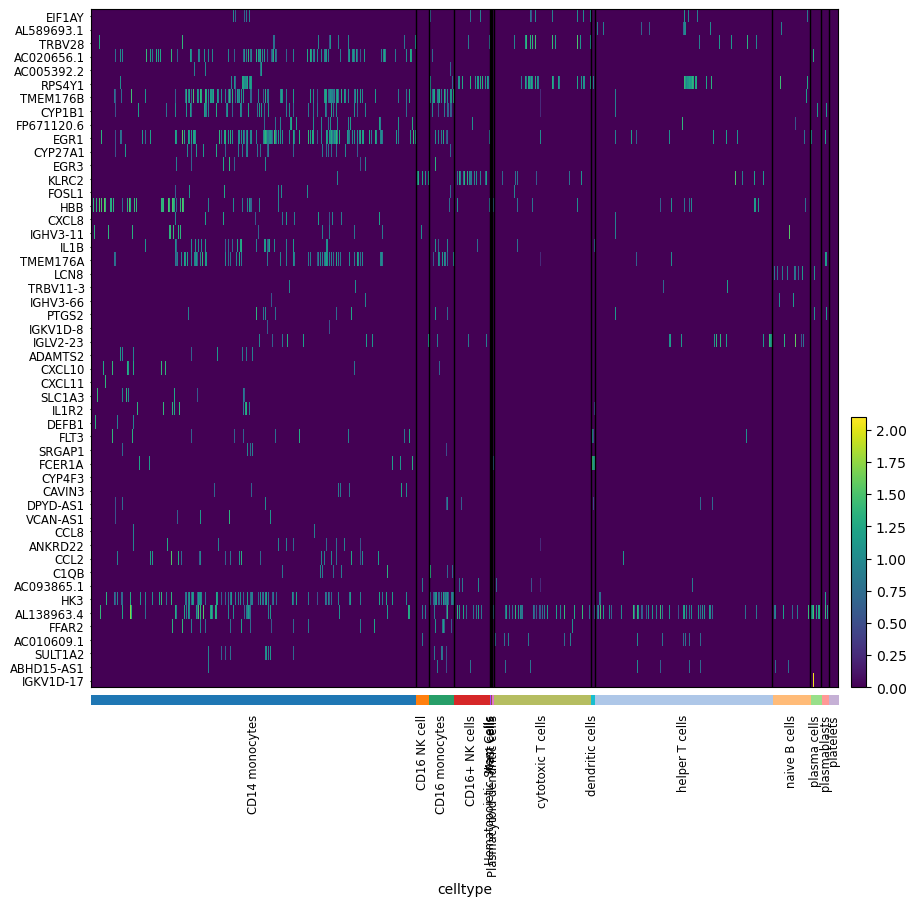

In [72]:
sc.pl.heatmap(adata, genes_to_show, groupby='celltype', swap_axes=True,
              log = True)

GO enrichment

In [54]:
import gseapy as gp

In [55]:
gp.get_library_name()

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_2024',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
 'Descartes_Cell_Types_and_Tissue_2021',
 'Diabetes_Perturbatio

In [ ]:
#'GO_Biological_Process_2023',
#'KEGG_2021_Human'

In [78]:
enr = gp.enrichr(gene_list=scvi_de_filter.index.tolist(), gene_sets=['KEGG_2021_Human'], organism='human', outdir=None, background=adata.var_names.tolist())

In [79]:
enr.results

Gene_set                                               Term  \
0    KEGG_2021_Human                            IL-17 signaling pathway   
1    KEGG_2021_Human  Viral protein interaction with cytokine and cy...   
2    KEGG_2021_Human             Cytokine-cytokine receptor interaction   
3    KEGG_2021_Human                                         Amoebiasis   
4    KEGG_2021_Human                                Coronavirus disease   
..               ...                                                ...   
110  KEGG_2021_Human                   Herpes simplex virus 1 infection   
111  KEGG_2021_Human                                        Endocytosis   
112  KEGG_2021_Human                         PI3K-Akt signaling pathway   
113  KEGG_2021_Human                     Human papillomavirus infection   
114  KEGG_2021_Human                                 Huntington disease   

          P-value  Adjusted P-value  Old P-value  Old adjusted P-value  \
0    8.145444e-12      9.367260e-10            0                     0   
1    4.177679e-07      2.286354e-05            0                     0   
2    5.964403e-07      2.286354e-05            0                     0   
3    1.160213e-05      3.142810e-04            0                     0   
4    1.366439e-05      3.142810e-04            0                     0   
..            ...               ...          ...                   ...   
110  5.749442e-01      5.956629e-01            0                     0   
111  6.301366e-01      6.470152e-01            0                     0   
112  6.410977e-01      6.524446e-01            0                     0   
113  6.532326e-01      6.532326e-01            0                     0   
114  6.532326e-01      6.532326e-01            0                     0   

     Odds Ratio  Combined Score  \
0     42.007070     1072.590141   
1     24.635945      361.861126   
2     12.868555      184.435818   
3     19.303359      219.369576   
4     10.033277      112.379895   
..          ...             ...   
110    1.044586        0.578160   
111    1.014368        0.468454   
112    0.984268        0.437579   
113    0.951957        0.405364   
114    0.951957        0.405364   

                                                 Genes  
0    FOSL1;CXCL10;CXCL8;IL1B;CCL2;PTGS2;S100A9;CXCL...  
1                  CXCL10;CXCL11;CCL8;CXCL8;CCL2;CXCL2  
2       CXCL10;CXCL11;CCL8;CXCL8;IL1R2;IL1B;CCL2;CXCL2  
3                     SERPINB10;CXCL8;IL1R2;IL1B;CXCL2  
4              C1QB;CXCL10;C1QA;CXCL8;IL1B;CCL2;RPS4Y1  
..                                                 ...  
110                                          IL1B;CCL2  
111                                              FOLR3  
112                                               FLT3  
113                                              PTGS2  
114                                             SLC1A3  

[115 rows x 9 columns]

In [82]:
pathways_to_show = enr.results.sort_values(by='Adjusted P-value')
pathways_to_show.head(20)

Gene_set                                               Term  \
0   KEGG_2021_Human                            IL-17 signaling pathway   
1   KEGG_2021_Human  Viral protein interaction with cytokine and cy...   
2   KEGG_2021_Human             Cytokine-cytokine receptor interaction   
3   KEGG_2021_Human                                         Amoebiasis   
4   KEGG_2021_Human                                Coronavirus disease   
5   KEGG_2021_Human                                            Malaria   
6   KEGG_2021_Human                                     Chagas disease   
7   KEGG_2021_Human                        Chemokine signaling pathway   
8   KEGG_2021_Human                              TNF signaling pathway   
9   KEGG_2021_Human                                          Pertussis   
10  KEGG_2021_Human                               Rheumatoid arthritis   
12  KEGG_2021_Human                         Hematopoietic cell lineage   
13  KEGG_2021_Human               Toll-like receptor signaling pathway   
11  KEGG_2021_Human  AGE-RAGE signaling pathway in diabetic complic...   
14  KEGG_2021_Human                       NF-kappa B signaling pathway   
15  KEGG_2021_Human                    Staphylococcus aureus infection   
16  KEGG_2021_Human                                      Legionellosis   
17  KEGG_2021_Human                                        Influenza A   
18  KEGG_2021_Human                NOD-like receptor signaling pathway   
19  KEGG_2021_Human                            Ovarian steroidogenesis   

         P-value  Adjusted P-value  Old P-value  Old adjusted P-value  \
0   8.145444e-12      9.367260e-10            0                     0   
1   4.177679e-07      2.286354e-05            0                     0   
2   5.964403e-07      2.286354e-05            0                     0   
3   1.160213e-05      3.142810e-04            0                     0   
4   1.366439e-05      3.142810e-04            0                     0   
5   2.177155e-05      4.172881e-04            0                     0   
6   4.160550e-05      6.191785e-04            0                     0   
7   4.307329e-05      6.191785e-04            0                     0   
8   6.232856e-05      7.964204e-04            0                     0   
9   1.552555e-04      1.785438e-03            0                     0   
10  2.584237e-04      2.701702e-03            0                     0   
12  4.225989e-04      3.633308e-03            0                     0   
13  4.423158e-04      3.633308e-03            0                     0   
11  3.850604e-04      3.633308e-03            0                     0   
14  6.771295e-04      5.191326e-03            0                     0   
15  1.237506e-03      8.894577e-03            0                     0   
16  1.718669e-03      1.162629e-02            0                     0   
17  2.579158e-03      1.647795e-02            0                     0   
18  3.676664e-03      2.225349e-02            0                     0   
19  5.378791e-03      3.092805e-02            0                     0   

    Odds Ratio  Combined Score  \
0    42.007070     1072.590141   
1    24.635945      361.861126   
2    12.868555      184.435818   
3    19.303359      219.369576   
4    10.033277      112.379895   
5    28.328571      304.104562   
6    14.572552      146.997383   
7    10.484926      105.400847   
8    13.326341      129.040171   
9    16.501852      144.728476   
10   14.342190      118.479544   
12   12.519691       97.266567   
13   12.362500       95.481602   
11   12.846320      100.999189   
14   10.982716       80.147997   
15   15.594579      104.400356   
16   13.824502       88.009621   
17    7.527990       44.869020   
18    6.795785       38.095470   
19   20.110360      105.082500   

                                                Genes  
0   FOSL1;CXCL10;CXCL8;IL1B;CCL2;PTGS2;S100A9;CXCL...  
1                 CXCL10;CXCL11;CCL8;CXCL8;CCL2;CXCL2  
2      CXCL10;CXCL11;CCL8;CXCL8;IL1R2;I

Comparisons

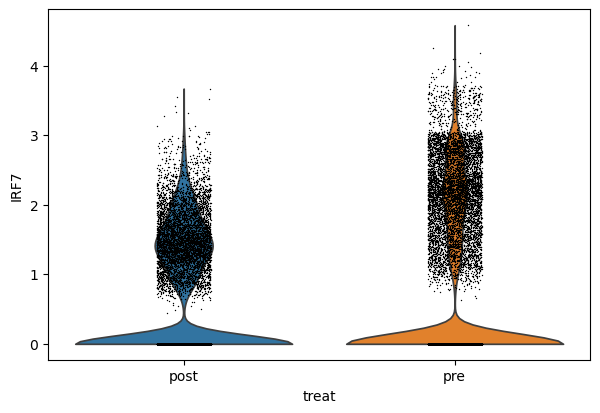

In [83]:
sc.pl.violin(adata[adata.obs.celltype=='CD14 monocytes'], 'IRF7', groupby='treat')

In [84]:
from scipy import stats

In [91]:
temp = adata[adata.obs.celltype == 'CD14 monocytes']
i = np.where(temp.var_names == 'IRF7')[0][0] # i is the position

In [92]:
a = temp[temp.obs.treat == 'pre'].X[:,i]
b = temp[temp.obs.treat == 'post'].X[:,i] # select all the cells (rows) and gene i

In [96]:
# Convert to dense arrays if they are sparse
if not isinstance(a, np.ndarray):
    a = a.toarray().flatten()
if not isinstance(b, np.ndarray):
    b = b.toarray().flatten()

In [97]:
stats.mannwhitneyu(a, b)

MannwhitneyuResult(statistic=125198480.0, pvalue=2.4270316217786885e-18)